# Data Loading, Cleaning and Feature Selection
The following tasks are executed:
- Data is loaded from raw files
- Columnnames are fixed
- Columns get correct object type
- Class columns are put as the last columns
- Missing data is replaced by NaN
- Data characteristics are visualized
- Missing data is visualized
- Data is saved to a new, cleaned file as a df

## Parameters

In [1]:
dataset_name = "omxs30"
class_name = "LongTrend"

filenameprefix = dataset_name + "_" + class_name
filenamesuffix = ''
filenameXsuffix = filenamesuffix
filenameysuffix = filenamesuffix

image_save_directory = '02_Training_Data/images'
filedataresultdirectory = '02_Training_Data'
#filedataresultdirectory = '03_Test_Prepared_Data'
#image_save_directory = '03_Test_Prepared_Data/images'

data_file = filedataresultdirectory + "/" + filenameprefix + "_dataset.csv"
print("Source path: ", data_file)

#To save time in the generation of test data and to skip the feature analysis, set this option to false. For training 
#data, set it to true.
#do_feature_analysis = True
skip_feature_analysis = False
skip_feature_selection = False

missingValueModelPath = filedataresultdirectory + "/" + filenameprefix + "_missing_value_model" + filenameXsuffix + ".csv"
X_filename = filedataresultdirectory + "/" + filenameprefix + "_X" + filenameXsuffix + ".csv"
y_filename = filedataresultdirectory + "/" + filenameprefix + "_y" + filenameysuffix + ".csv"
ylabel_filename = filedataresultdirectory + "/" + filenameprefix + "_y" + "_labels" + filenameysuffix + ".csv"
X_filename_selected_feature_column = filedataresultdirectory + "/" + filenameprefix + "_X" + filenameXsuffix + "_selected_feature_columns.csv"
filename_timegraph = filedataresultdirectory + "/" + filenameprefix + "_timegraph" + filenameXsuffix + ".csv"

print("Missing value path: ", missingValueModelPath)
print("Save features to X: ", X_filename)
print("Save features to y: ", y_filename)
print("Define y labels to ", ylabel_filename)
print("Selected feature column file name: ", X_filename_selected_feature_column)
print("Time graph path: ", filename_timegraph)

print("Feature analysis to be skipped: ", skip_feature_analysis)
print("Feature selection to be skipped: ", skip_feature_selection)

Source path:  02_Training_Data/omxs30_LongTrend_dataset.csv
Missing value path:  02_Training_Data/omxs30_LongTrend_missing_value_model.csv
Save features to X:  02_Training_Data/omxs30_LongTrend_X.csv
Save features to y:  02_Training_Data/omxs30_LongTrend_y.csv
Define y labels to  02_Training_Data/omxs30_LongTrend_y_labels.csv
Selected feature column file name:  02_Training_Data/omxs30_LongTrend_X_selected_feature_columns.csv
Time graph path:  02_Training_Data/omxs30_LongTrend_timegraph.csv
Feature analysis to be skipped:  False
Feature selection to be skipped:  False


## Load Libraries

In [14]:
# Import libraries
#%matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.ticker import FuncFormatter, MaxNLocator
import DatavisualizationFunctions as vis
import DataSupportFunctions as sup

#Global settings
np.set_printoptions(precision=3)

#Suppress print out in scientific notiation
np.set_printoptions(suppress=True)

#Load skip cell kernel extension
#Source: https://stackoverflow.com/questions/26494747/simple-way-to-choose-which-cells-to-run-in-ipython-notebook-during-run-all
#%%skip True  #skips cell
#%%skip False #won't skip
#should_skip = True
#%%skip $should_skip
%load_ext skip_kernel_extension

The skip_kernel_extension extension is already loaded. To reload it, use:
  %reload_ext skip_kernel_extension


## Load dataset

In [15]:
#Load dataset
df = pd.read_csv(data_file, sep=';').set_index('id') #Set ID to be the data id
display(df.head(1))

#=== Get classes into a dict ===#
class_labels = dict(zip(df[class_name].unique(), list(range(1,len(df[class_name].unique())+1, 1))))
#Load class labels instead
df_y_classes = pd.read_csv(ylabel_filename, delimiter=';', header=None)
class_labels = sup.inverse_dict(df_y_classes.set_index(df_y_classes.columns[0]).to_dict()[1])
print("Loaded  classes from file", class_labels)

#=== Define classes manually ===#
#class_labels = {
#    0 : 'class1',
#    1 : 'class2'
#}

print(class_labels)


#=== Define index name ===#
#Define name if there is no index name

#df.index.name = 'id'

#=== Drop alternative y values ===#
df=df.drop(['1dTrend', '5dTrend', '20dTrend'], axis=1)

#=== Reorder columns to have the class as the last column if it is not done yet ===#
df = df[[c for c in df if c not in [class_name]] + [class_name]]

#=== Use only a subset header ===#
#header = ['Elevation', 'Aspect', 'Slope', 
#          'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
#          'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
#          'Horizontal_Distance_To_Fire_Points'] + \
#         ['Wilderness_Area_{:d}'.format(i) for i in range(4)] + \
#         ['Soil_Type_{:d}'.format(i) for i in range(40)] + \
#          ['Cover_type']
# header=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
#         'marital-status', 'occupation', 'relationship', 'race', 'sex', 
#         'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Income50K']
#df.columns = header

#=== rename colums ===#
#df.rename(columns={'model.year':'year'}, inplace=True)

#Rename columns with " "
df.columns = [x.replace(" ", "_") for x in df.columns]
df.columns = [x.replace("/", "-") for x in df.columns]

print("df size : ", df.shape)
display(df.head(5))

MA2Norm   MA5Norm   MA8Norm  MA10Norm  MA13Norm  MA15Norm  MA18Norm  \
id                                                                          
400 -0.000887  0.005474  0.006129  0.007285  0.002936 -0.000072  0.001049   

     MA20Norm  MA22Norm  MA34Norm    ...      week_month__1  week_month__2  \
id                                   ...                                     
400  0.004271  0.005723 -0.000678    ...                  0              0   

     week_month__3  week_month__4  week_month__5  week_month__6  1dTrend  \
id                                                                         
400              1              0              0              0        0   

     5dTrend  20dTrend  LongTrend  
id                                 
400        0         1          1  

[1 rows x 120 columns]

Loaded  classes from file {0: 'negative', 1: 'positive'}
{0: 'negative', 1: 'positive'}
df size :  (7687, 117)


MA2Norm   MA5Norm   MA8Norm  MA10Norm  MA13Norm  MA15Norm  MA18Norm  \
id                                                                          
400 -0.000887  0.005474  0.006129  0.007285  0.002936 -0.000072  0.001049   
401 -0.000501  0.000770  0.004823  0.005799  0.003158  0.000472 -0.001806   
402  0.004116  0.004845  0.011318  0.011539  0.012066  0.009370  0.006001   
403  0.000466  0.004928  0.009813  0.011324  0.012705  0.010773  0.007302   
404 -0.004963 -0.004325 -0.002414  0.000777  0.002350  0.001898 -0.001364   

     MA20Norm  MA22Norm  MA34Norm    ...      month_year__10  month_year__11  \
id                                   ...                                       
400  0.004271  0.005723 -0.000678    ...                   0               0   
401  0.001748  0.004173 -0.001803    ...                   0               0   
402  0.007862  0.010850  0.006276    ...                   0               0   
403  0.006661  0.009984  0.006794    ...                   0               0   
404 -0.003247 -0.001553 -0.003386    ...                   0               0   

     month_year__12  week_month__1  week_month__2  week_month__3  \
id                                                                 
400               0              0              0              1   
401               0              0              0              1   
402               0              0              0              1   
403               0              0              0              1   
404               0              0              0              0   

     week_month__4  week_month__5  week_month__6  LongTrend  
id                                                           
400              0              0              0          1  
401              0              0              0          1  
402              0              0              0          1  
403              0              0              0          1  
404              1              0              0          1  

[5 rows x 117 columns]

In [8]:
#Load original data for visualization
import matplotlib.dates as mdates
import datetime

df_timegraph = pd.read_csv(filename_timegraph, delimiter=';').set_index('id')
df_timegraph['Time'] = pd.to_datetime(df_timegraph['Time'])
df_timegraph['Time'].apply(mdates.date2num)
print("Loaded feature names for time graph={}".format(df_timegraph.columns))
print("X. Shape={}".format(df_timegraph.shape))
display(df_timegraph.head())

Loaded feature names for time graph=Index(['Time', 'High', 'Low', 'Close'], dtype='object')
X. Shape=(7687, 4)


Time    High     Low   Close
id                                    
400 1988-05-09  129.71  129.71  129.71
401 1988-05-10  129.84  129.84  129.84
402 1988-05-11  128.78  128.78  128.78
403 1988-05-13  128.66  128.66  128.66
404 1988-05-16  129.95  129.95  129.95

## Data Cleanup

In [9]:
print("feature columns: {}".format(df.columns[0:-1]))

feature columns: Index(['MA2Norm', 'MA5Norm', 'MA10Norm', 'MA18Norm', 'MA20Norm', 'MA40Norm',
       'MA50Norm', 'MA75Norm', 'MA100Norm', 'MA125Norm', 'MA150Norm',
       'MA175Norm', 'MA200Norm', 'MA225Norm', 'MA250Norm', 'MA275Norm',
       'MA300Norm', 'MA325Norm', 'MA350Norm', 'MA375Norm', 'MA400Norm',
       'MA2NormDiff', 'MA5NormDiff', 'MA10NormDiff', 'MA18NormDiff',
       'MA20NormDiff', 'MA40NormDiff', 'MA50NormDiff', 'MA75NormDiff',
       'MA100NormDiff', 'MA125NormDiff', 'MA150NormDiff', 'MA175NormDiff',
       'MA200NormDiff', 'MA225NormDiff', 'MA250NormDiff', 'MA275NormDiff',
       'MA300NormDiff', 'MA325NormDiff', 'MA350NormDiff', 'MA375NormDiff',
       'MA400NormDiff', 'RSI2', 'RSI5', 'RSI14', 'RSI20', 'RSI25',
       'Stoch_slowk13', 'Stoch_slowd8', 'MACD12_26_9', 'MACD12_26_9Diff',
       'MACD12_26_9DiffDirChange', 'month_of_year', 'week_of_year',
       'day_of_year', 'day_of_month', 'day_of_week'],
      dtype='object')


In [10]:
#Strip all string values to find the missing data
from pandas.api.types import is_string_dtype

for col in df.columns:
    if is_string_dtype(df[col]):
        print("Strip column {}".format(col))
        df[col]=df[col].str.strip()

In [11]:
#Replace values for missing data

#=== Replace all missing values with np.nan
for col in df.columns[0:-1]:
    df[col] = df[col].replace('?', np.nan)
    #df[col] = df[col].replace('unknown', np.nan)
    
print("Missing data in the data frame")
print(sum(df.isna().sum()))

Missing data in the data frame
0


In [12]:
#Get column types
print("Column types:")
print(df.dtypes)
print("\n")

Column types:
MA2Norm                     float64
MA5Norm                     float64
MA10Norm                    float64
MA18Norm                    float64
MA20Norm                    float64
MA40Norm                    float64
MA50Norm                    float64
MA75Norm                    float64
MA100Norm                   float64
MA125Norm                   float64
MA150Norm                   float64
MA175Norm                   float64
MA200Norm                   float64
MA225Norm                   float64
MA250Norm                   float64
MA275Norm                   float64
MA300Norm                   float64
MA325Norm                   float64
MA350Norm                   float64
MA375Norm                   float64
MA400Norm                   float64
MA2NormDiff                 float64
MA5NormDiff                 float64
MA10NormDiff                float64
MA18NormDiff                float64
MA20NormDiff                float64
MA40NormDiff                float64
MA50NormDiff  

## Get Data Characteristics

In [14]:
# Get number of samples
numSamples=df.shape[0]
print("Number of samples={}".format(numSamples))

# Get number of features
numFeatures=df.shape[1]-1
print("Number of features={}".format(numFeatures))

#Get the number of classes for the supervised learning
numClasses = df[class_name].value_counts().shape[0]
print("Number of classes={}".format(numClasses))

Number of samples=7687
Number of features=57
Number of classes=2


## Analyse and Transform time series

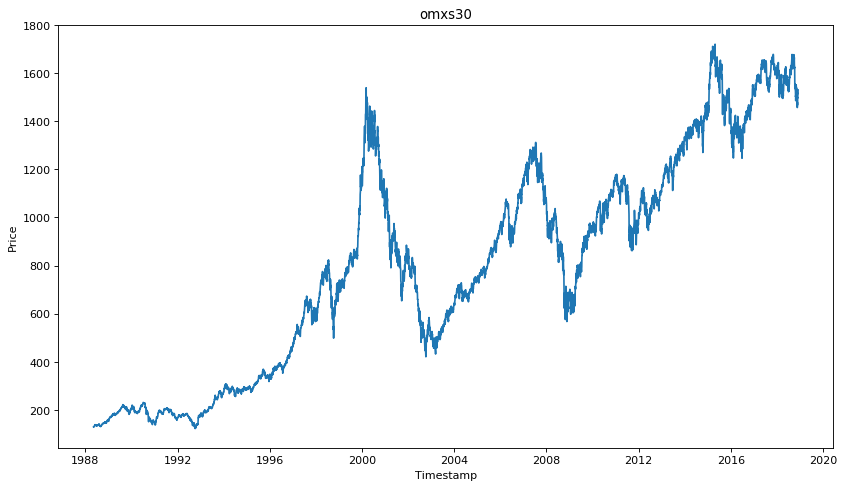

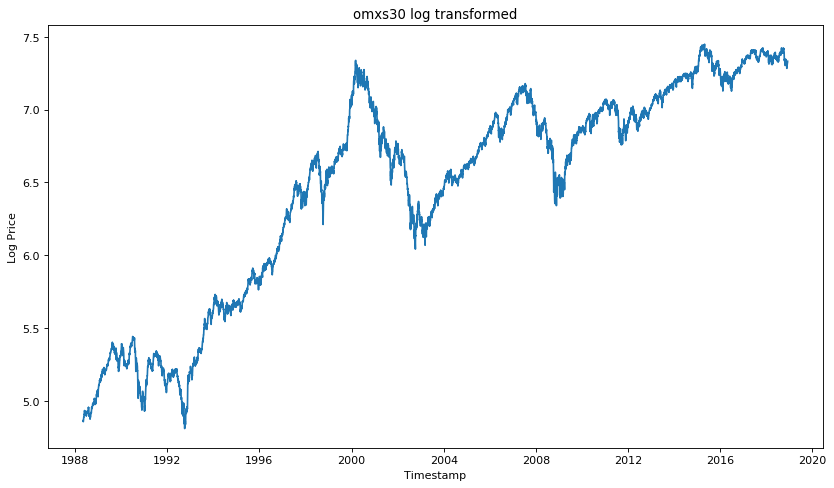

In [17]:
datatitle = dataset_name

plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_timegraph['Time'],df_timegraph['Close']) #To get scatter plot, add 'o' as the last parameter
plt.title(datatitle)
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.show()

plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_timegraph['Time'],np.log(df_timegraph['Close']))
plt.title(datatitle + ' log transformed')
plt.xlabel("Timestamp")
plt.ylabel("Log Price")
plt.show()

## Analyse the Features Individually

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from statsmodels import robust
import itertools

# Calculate Interval length according to Freedman und Diaconis
def getNumberOfIntervals(valueDistribution):
    numFeatures = valueDistribution.shape[0]
    featuregroup = valueDistribution.value_counts().sort_index(ascending=True)
    numUniqueFeatures = featuregroup.shape[0]
    print("Number of unique features {} ".format(numUniqueFeatures))

    n = valueDistribution.shape[0]
    q75 = np.quantile(valueDistribution, 0.75)
    q25 = np.quantile(valueDistribution, 0.25)
    minValue = min(valueDistribution)
    maxValue = max(valueDistribution)
    IQR = q75 - q25
    hn = 2 * IQR / np.power(n, 1 / 3)
    if hn != 0:
        hnIntervalCount = int(round((maxValue - minValue) / hn, 0))
    else:
        hnIntervalCount = 0

        # If unique features is too big, i.e. > 100, then reduce to max 100 bins for the historgram
    if hnIntervalCount > 0 and numUniqueFeatures >= hnIntervalCount:
        numIntervals = hnIntervalCount
        print("Number of bins with Freedman und Diaconis: ", numIntervals)
    elif hn > 0 and numUniqueFeatures < hnIntervalCount:
        numIntervals = numUniqueFeatures
        print("Number of bins = number of features {}: ", numIntervals)
    else:
        if (numUniqueFeatures > 100):
            bins = np.linspace(min(featuregroup), max(featuregroup), 100)
            print("Number of bins limited to 100: ", bins.shape[0])
        else:
            bins = np.linspace(min(featuregroup), max(featuregroup), featuregroup.shape[0])
            print("Number of bins <= 100: ", bins.shape[0])
        numIntervals = bins.shape[0]
    print(
        "n={}, q25={:.2f}, q75={:.2f}, "
        "min={:.2f}, max={:.2f}, "
        "interval length={:.2f}. Number of intervals={}".format(n,q25,q75,minValue,maxValue,hn,numIntervals))
    return numIntervals

def paintHistogram(df, colName):
    # colName = 'age'
    # Create the histogram data
    mean = df[colName].mean()
    median = df[colName].median()
    sigma = df[colName].std()
    s_mad = robust.mad(df[colName])
    skew = df[colName].skew()
    kurtosis = df[colName].kurtosis()

    bins = getNumberOfIntervals(df[colName])

    # Plot the graph
    fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.xlabel(colName)
    plt.ylabel('Probability')
    plt.title('{} Histogram'.format(colName))

    # bar = plt.bar(featuregroup.index, featuregroup/numFeatures, width=1.0, capsize=10, edgecolor='black')
    hist = plt.hist(df[colName], bins, density=True, edgecolor='black', stacked=True)
    plt.gca().axvline(x=mean, color='red', alpha=0.8, linewidth=2)  # alpha =transperacy
    plt.gca().axvline(x=mean + 2*sigma, color='red', alpha=0.8, linewidth=2)  # alpha =transperacy
    plt.gca().axvline(x=mean - 2*sigma, color='red', alpha=0.8, linewidth=2)  # alpha =transperacy
	
    plt.gca().axvline(x=median, color='green', alpha=0.8, linewidth=2)  # alpha =transperacy
    plt.gca().axvline(x=median + 2*s_mad, color='green', alpha=0.8, linewidth=2)  # alpha =transperacy
    plt.gca().axvline(x=median - 2*s_mad, color='green', alpha=0.8, linewidth=2)  # alpha =transperacy
	
    # Add text
    plt.text(mean * 1.01, plt.gca().get_ylim()[1] * 0.97, 'Mean={}'.format(round(mean, 2)))
    plt.text((mean + 2*sigma) * 1.01, plt.gca().get_ylim()[1] * 0.95, 'Mean+2std={}'.format(round(mean + 2*sigma, 2)))
    plt.text((mean - 2*sigma) * 1.01, plt.gca().get_ylim()[1] * 0.95, 'Mean-2std={}'.format(round(mean - 2*sigma, 2)))
	
    plt.text(median * 1.01, plt.gca().get_ylim()[1] * 0.90, 'Median={}'.format(round(median, 2)))
    plt.text((median + 2*s_mad) * 1.01, plt.gca().get_ylim()[1] * 0.93, 'Median+2s_mad={}'.format(round(median + 2*s_mad, 2)))
    plt.text((median - 2*s_mad) * 1.01, plt.gca().get_ylim()[1] * 0.93, 'Median-2s_mad={}'.format(round(median - 2*s_mad, 2)))
    plt.show()

    # Get data
    print("Feature characteristics for {}:".format(colName))
    print("Min value = ", min(df[colName]))
    print("Max value = ", max(df[colName]))
    print("Mean = ", round(mean, 2))
    print("Median =", median)
    print("Standard deviation =", round(sigma, 4))
    print("Skew =", round(skew, 4))
    print("kurtosis =", round(kurtosis, 4))

    return fig

fig = paintHistogram(df, df.columns[i])
plt.figure(fig.number)
plt.savefig(image_save_directory + '/{}-{}'.format(i, df.columns[i]), dpi=300)

Column MA2Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  134
n=7687, q25=-0.00, q75=0.00, min=-0.05, max=0.05, interval length=0.00. Number of intervals=134
Feature characteristics for MA2Norm:
Min value =  -0.05218524078195865
Max value =  0.04599550597865965
Mean =  -0.0
Median = -0.0003159235668705834
Standard deviation = 0.007
Skew = 0.0669
kurtosis = 4.3275


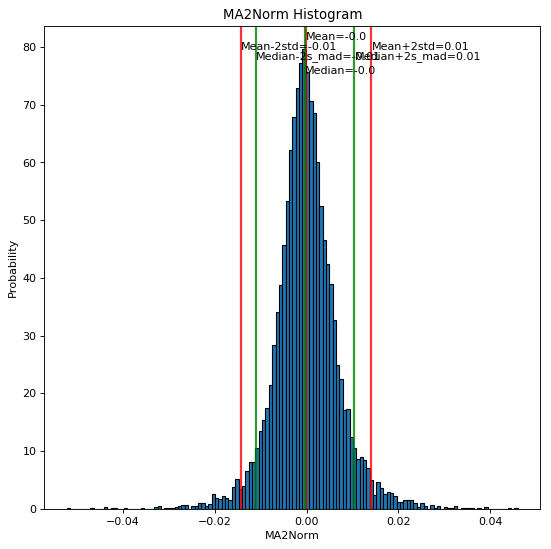

Column MA5Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  116
n=7687, q25=-0.01, q75=0.01, min=-0.10, max=0.10, interval length=0.00. Number of intervals=116
Feature characteristics for MA5Norm:
Min value =  -0.09645756457564714
Max value =  0.09596046346939492
Mean =  -0.0
Median = -0.0016486021957969172
Standard deviation = 0.0154
Skew = 0.4687
kurtosis = 3.2531


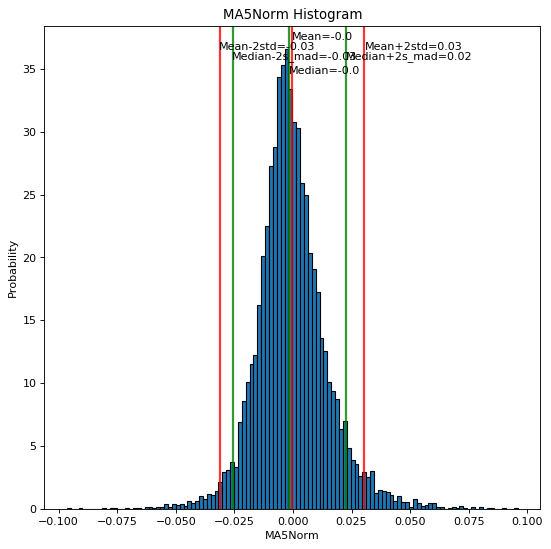

Column MA10Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  112
n=7687, q25=-0.01, q75=0.01, min=-0.13, max=0.16, interval length=0.00. Number of intervals=112
Feature characteristics for MA10Norm:
Min value =  -0.12773796727576628
Max value =  0.1607258659989083
Mean =  -0.0
Median = -0.0032478737828183194
Standard deviation = 0.023
Skew = 0.6774
kurtosis = 3.2092


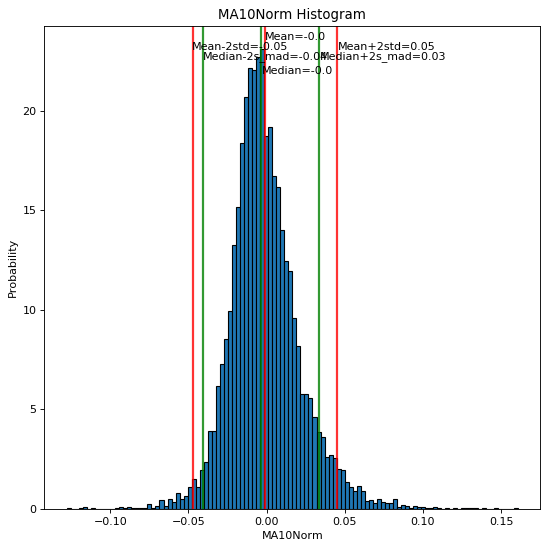

Column MA18Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  104
n=7687, q25=-0.02, q75=0.01, min=-0.15, max=0.23, interval length=0.00. Number of intervals=104
Feature characteristics for MA18Norm:
Min value =  -0.14944006288822045
Max value =  0.2285208014525141
Mean =  -0.0
Median = -0.006003612569494543
Standard deviation = 0.0316
Skew = 0.8296
kurtosis = 2.8857


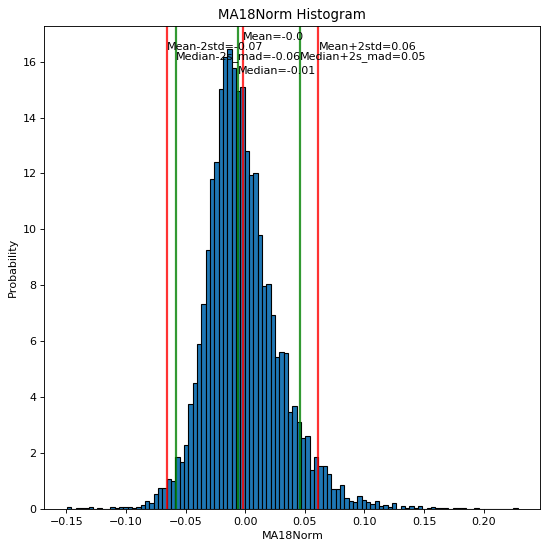

Column MA20Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  101
n=7687, q25=-0.02, q75=0.01, min=-0.16, max=0.24, interval length=0.00. Number of intervals=101
Feature characteristics for MA20Norm:
Min value =  -0.15528879610299212
Max value =  0.2366127323509575
Mean =  -0.0
Median = -0.0064812613172874406
Standard deviation = 0.0335
Skew = 0.8512
kurtosis = 2.828


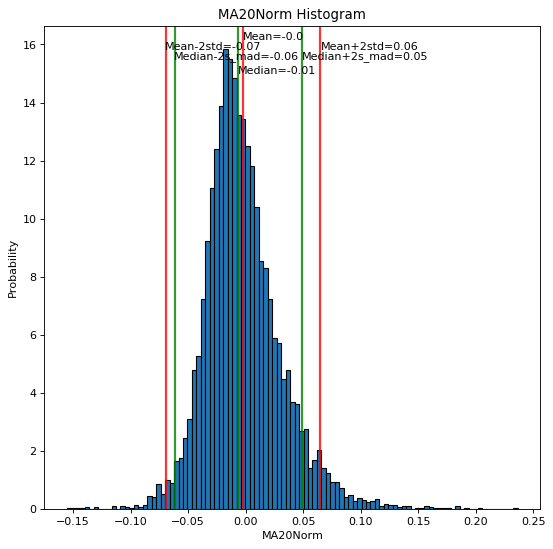

Column MA40Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  93
n=7687, q25=-0.03, q75=0.02, min=-0.20, max=0.31, interval length=0.01. Number of intervals=93
Feature characteristics for MA40Norm:
Min value =  -0.2004517476989117
Max value =  0.3076092998210879
Mean =  -0.0
Median = -0.011700748314441102
Standard deviation = 0.05
Skew = 0.9246
kurtosis = 2.7276


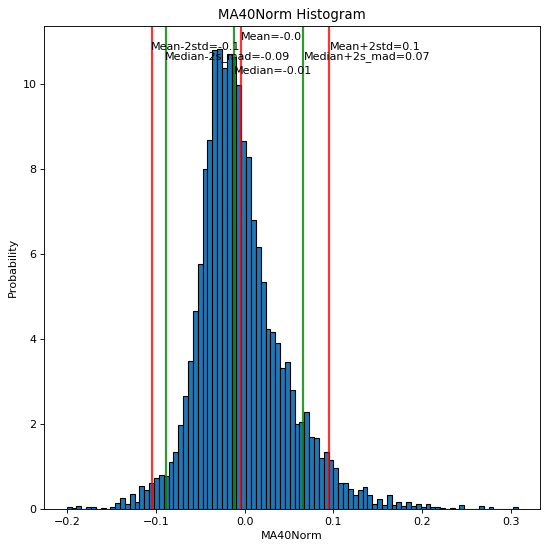

Column MA50Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  90
n=7687, q25=-0.04, q75=0.02, min=-0.21, max=0.34, interval length=0.01. Number of intervals=90
Feature characteristics for MA50Norm:
Min value =  -0.2107030323564291
Max value =  0.3441326362230984
Mean =  -0.01
Median = -0.01485895813561096
Standard deviation = 0.057
Skew = 0.9705
kurtosis = 2.7091


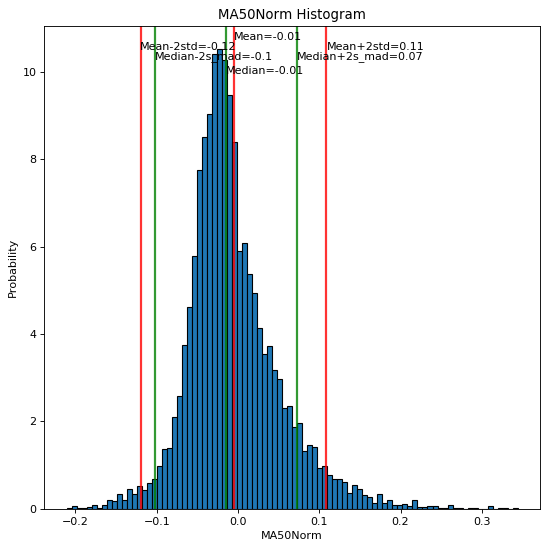

Column MA75Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  82
n=7687, q25=-0.05, q75=0.02, min=-0.22, max=0.41, interval length=0.01. Number of intervals=82
Feature characteristics for MA75Norm:
Min value =  -0.22466133278917533
Max value =  0.4071201668538447
Mean =  -0.01
Median = -0.02120223005169961
Standard deviation = 0.0724
Skew = 1.071
kurtosis = 2.4994


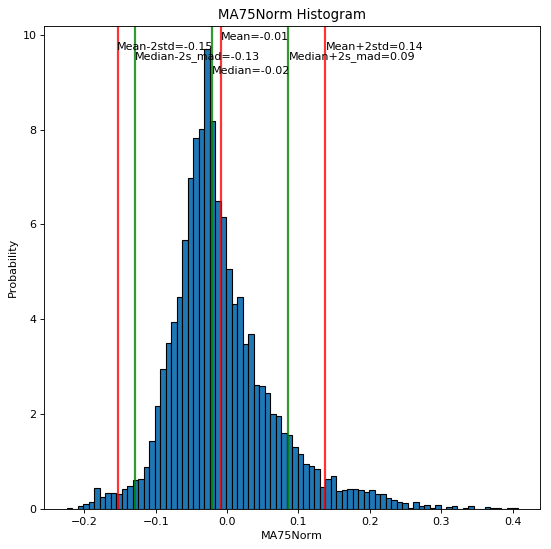

Column MA100Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  76
n=7687, q25=-0.06, q75=0.03, min=-0.26, max=0.44, interval length=0.01. Number of intervals=76
Feature characteristics for MA100Norm:
Min value =  -0.2555756787492979
Max value =  0.4421622463602546
Mean =  -0.01
Median = -0.027345241518113676
Standard deviation = 0.0859
Skew = 1.1255
kurtosis = 2.3348


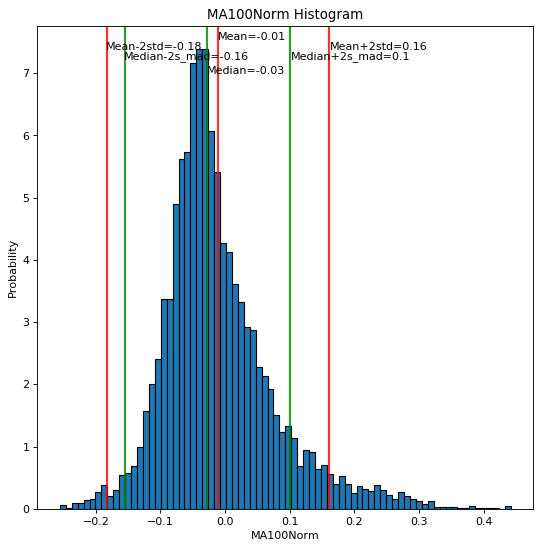

Column MA125Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  74
n=7687, q25=-0.08, q75=0.03, min=-0.29, max=0.50, interval length=0.01. Number of intervals=74
Feature characteristics for MA125Norm:
Min value =  -0.2939653599299363
Max value =  0.4972511854926981
Mean =  -0.01
Median = -0.0318073838024816
Standard deviation = 0.0979
Skew = 1.1568
kurtosis = 2.2019


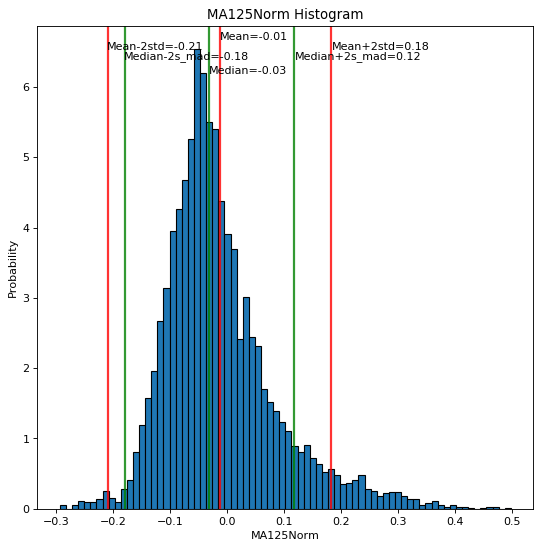

Column MA150Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  72
n=7687, q25=-0.09, q75=0.03, min=-0.32, max=0.53, interval length=0.01. Number of intervals=72
Feature characteristics for MA150Norm:
Min value =  -0.3205693854496657
Max value =  0.5304258509782107
Mean =  -0.02
Median = -0.036954525635435546
Standard deviation = 0.1084
Skew = 1.1743
kurtosis = 2.1279


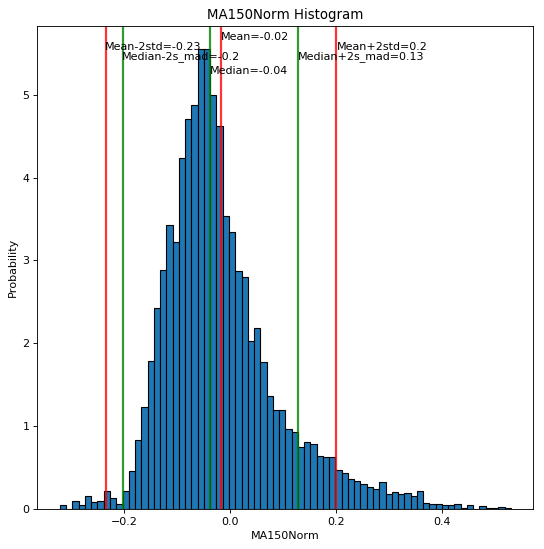

Column MA175Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  70
n=7687, q25=-0.09, q75=0.03, min=-0.34, max=0.55, interval length=0.01. Number of intervals=70
Feature characteristics for MA175Norm:
Min value =  -0.3409960311523413
Max value =  0.5457910604793557
Mean =  -0.02
Median = -0.04269838825582823
Standard deviation = 0.1177
Skew = 1.1677
kurtosis = 1.9687


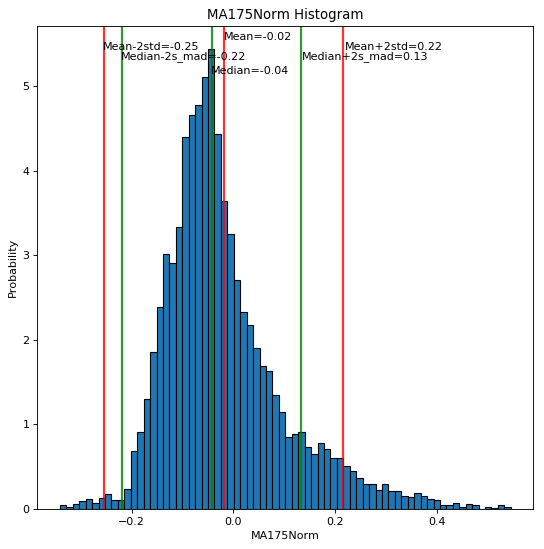

Column MA200Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  70
n=7687, q25=-0.10, q75=0.03, min=-0.36, max=0.58, interval length=0.01. Number of intervals=70
Feature characteristics for MA200Norm:
Min value =  -0.3575649014850423
Max value =  0.5783557699144379
Mean =  -0.02
Median = -0.04822581102943296
Standard deviation = 0.1263
Skew = 1.1546
kurtosis = 1.8145


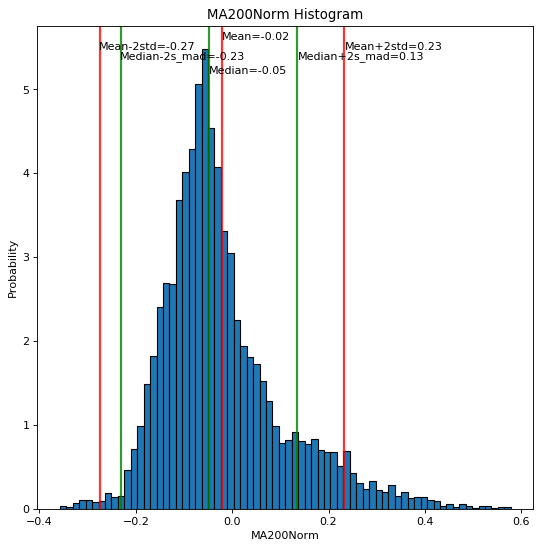

Column MA225Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  71
n=7687, q25=-0.11, q75=0.03, min=-0.37, max=0.62, interval length=0.01. Number of intervals=71
Feature characteristics for MA225Norm:
Min value =  -0.3726084112642615
Max value =  0.624454504038318
Mean =  -0.02
Median = -0.05251233313295218
Standard deviation = 0.1347
Skew = 1.1477
kurtosis = 1.704


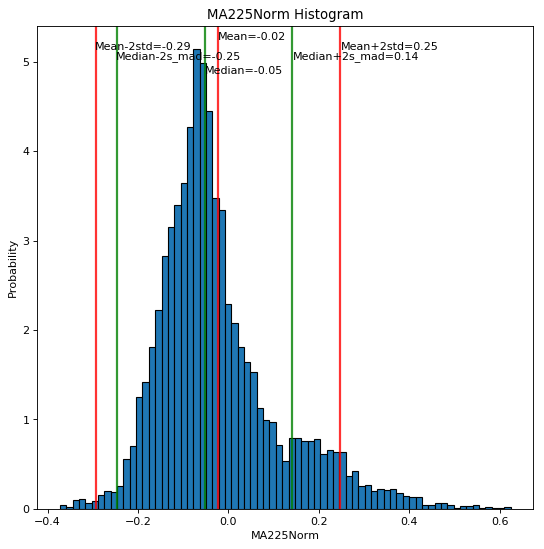

Column MA250Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  71
n=7687, q25=-0.12, q75=0.03, min=-0.39, max=0.64, interval length=0.01. Number of intervals=71
Feature characteristics for MA250Norm:
Min value =  -0.3872006400707715
Max value =  0.6433312272867596
Mean =  -0.03
Median = -0.057841383826416966
Standard deviation = 0.1431
Skew = 1.1508
kurtosis = 1.6178


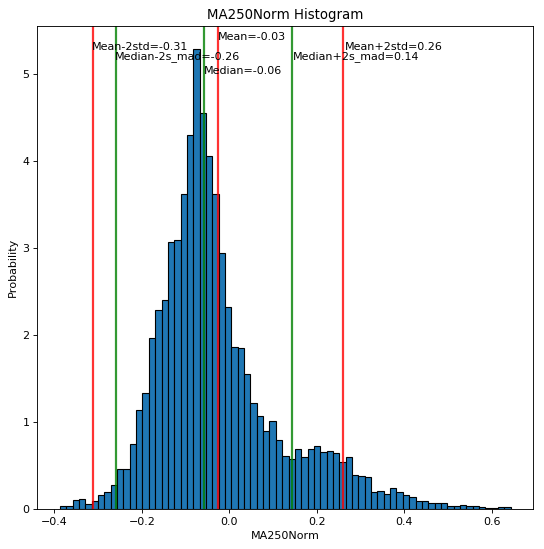

Column MA275Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  71
n=7687, q25=-0.12, q75=0.03, min=-0.40, max=0.67, interval length=0.02. Number of intervals=71
Feature characteristics for MA275Norm:
Min value =  -0.4000031932577313
Max value =  0.6692200144959343
Mean =  -0.03
Median = -0.06379649698472409
Standard deviation = 0.1513
Skew = 1.1725
kurtosis = 1.6145


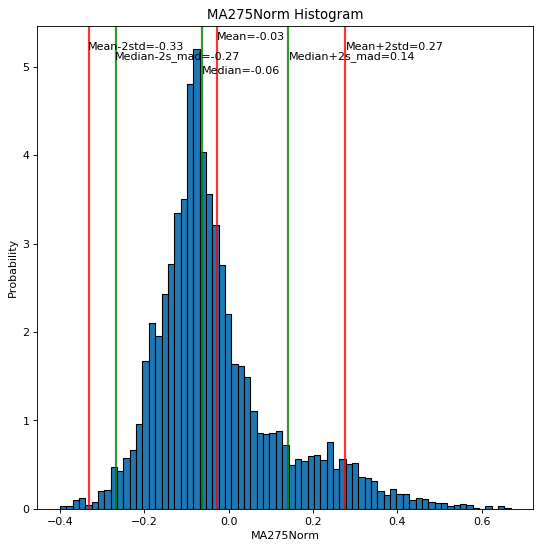

Column MA300Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  73
n=7687, q25=-0.13, q75=0.03, min=-0.41, max=0.70, interval length=0.02. Number of intervals=73
Feature characteristics for MA300Norm:
Min value =  -0.411281572596644
Max value =  0.7026428815433695
Mean =  -0.03
Median = -0.06908093896713549
Standard deviation = 0.1595
Skew = 1.2071
kurtosis = 1.6799


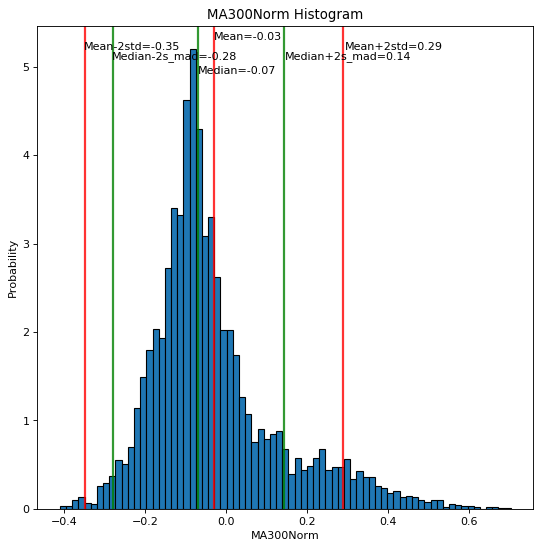

Column MA325Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  74
n=7687, q25=-0.13, q75=0.02, min=-0.42, max=0.74, interval length=0.02. Number of intervals=74
Feature characteristics for MA325Norm:
Min value =  -0.42232568053803576
Max value =  0.7356988761702966
Mean =  -0.03
Median = -0.0749230916373497
Standard deviation = 0.1672
Skew = 1.2409
kurtosis = 1.7448


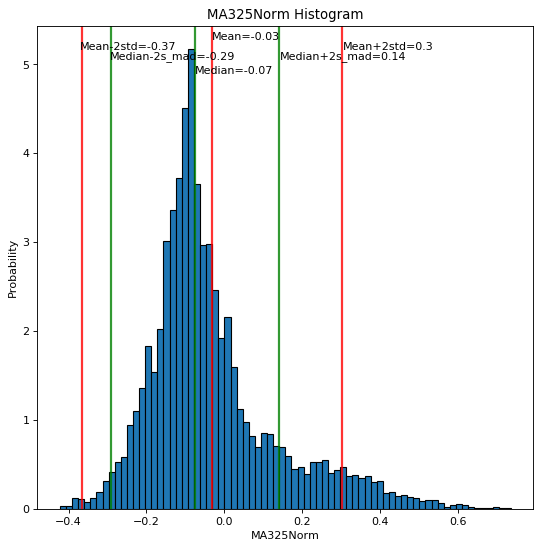

Column MA350Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  74
n=7687, q25=-0.14, q75=0.02, min=-0.43, max=0.77, interval length=0.02. Number of intervals=74
Feature characteristics for MA350Norm:
Min value =  -0.4344271840510137
Max value =  0.7693974893113349
Mean =  -0.03
Median = -0.07972117443553194
Standard deviation = 0.1745
Skew = 1.2744
kurtosis = 1.8214


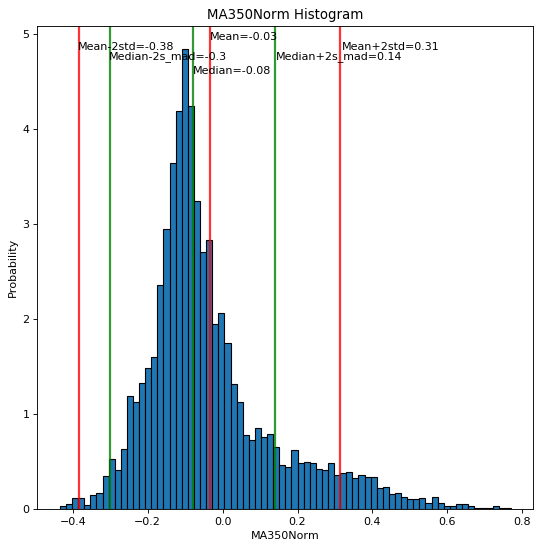

Column MA375Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  74
n=7687, q25=-0.14, q75=0.02, min=-0.45, max=0.80, interval length=0.02. Number of intervals=74
Feature characteristics for MA375Norm:
Min value =  -0.44683954648644203
Max value =  0.7974837794491461
Mean =  -0.04
Median = -0.08448856902101022
Standard deviation = 0.1812
Skew = 1.3061
kurtosis = 1.8968


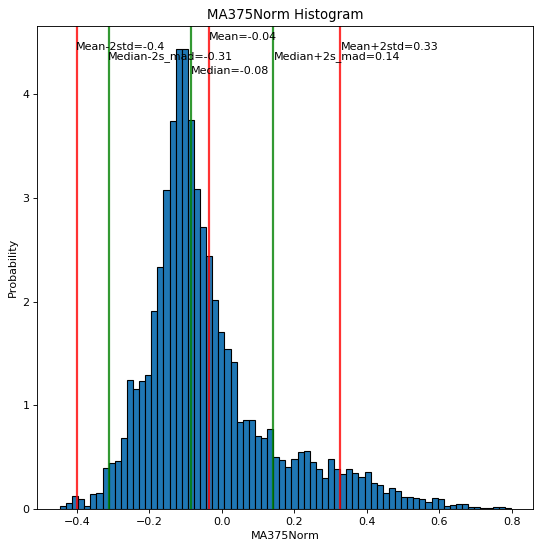

Column MA400Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  72
n=7687, q25=-0.15, q75=0.02, min=-0.45, max=0.82, interval length=0.02. Number of intervals=72
Feature characteristics for MA400Norm:
Min value =  -0.4532537256151911
Max value =  0.8210164839936754
Mean =  -0.04
Median = -0.0889776526087516
Standard deviation = 0.1875
Skew = 1.3414
kurtosis = 1.9977


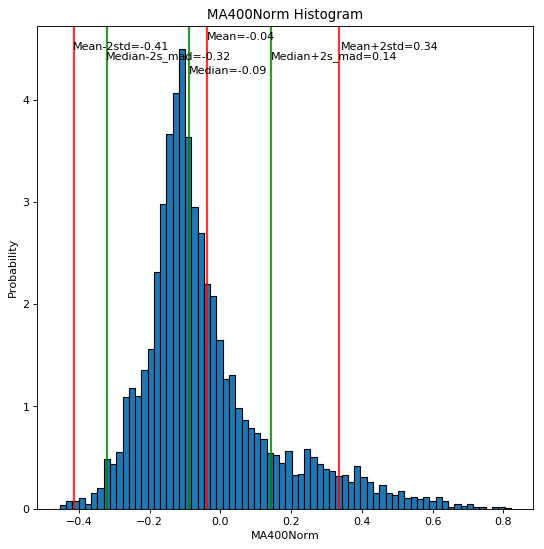

Column MA2NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  120
n=7687, q25=-0.01, q75=0.01, min=-0.07, max=0.05, interval length=0.00. Number of intervals=120
Feature characteristics for MA2NormDiff:
Min value =  -0.07049484763103052
Max value =  0.05493745307104738
Mean =  -0.0
Median = 0.00012415913045910702
Standard deviation = 0.0099
Skew = -0.327
kurtosis = 4.5574


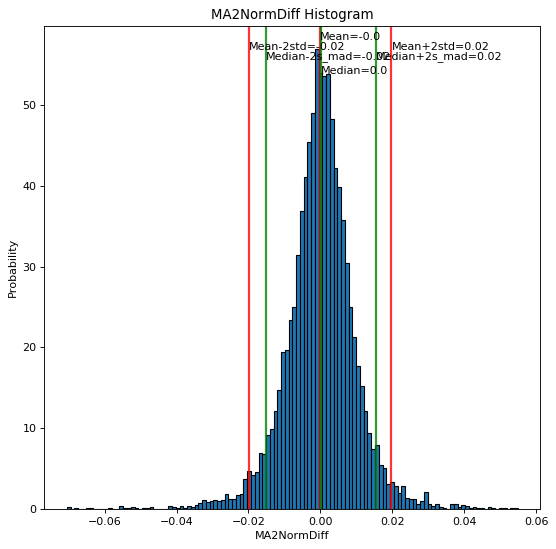

Column MA5NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  137
n=7687, q25=-0.01, q75=0.01, min=-0.10, max=0.08, interval length=0.00. Number of intervals=137
Feature characteristics for MA5NormDiff:
Min value =  -0.10133325706239146
Max value =  0.08217953343895837
Mean =  -0.0
Median = 0.0004696736474149501
Standard deviation = 0.0128
Skew = -0.5102
kurtosis = 5.1965


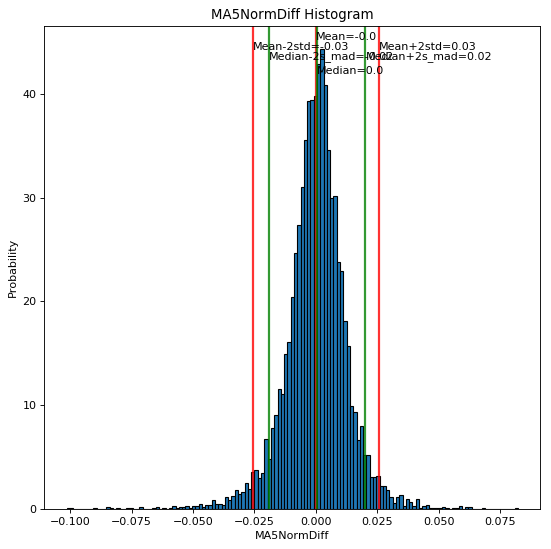

Column MA10NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  146
n=7687, q25=-0.01, q75=0.01, min=-0.12, max=0.08, interval length=0.00. Number of intervals=146
Feature characteristics for MA10NormDiff:
Min value =  -0.11702390639012362
Max value =  0.08346634033662326
Mean =  -0.0
Median = 0.0003837792344338672
Standard deviation = 0.0135
Skew = -0.5504
kurtosis = 5.8075


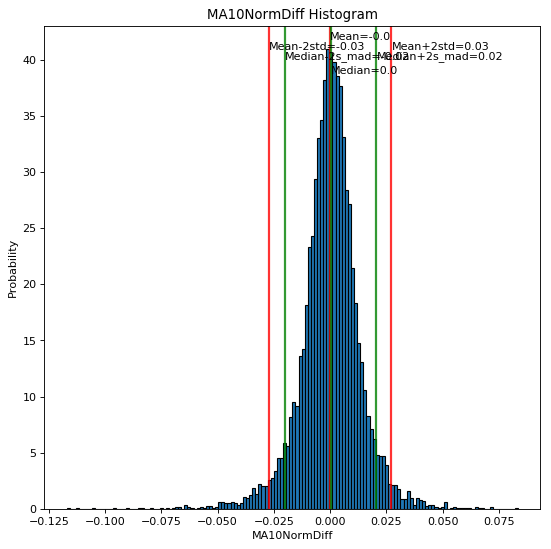

Column MA18NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  146
n=7687, q25=-0.01, q75=0.01, min=-0.12, max=0.08, interval length=0.00. Number of intervals=146
Feature characteristics for MA18NormDiff:
Min value =  -0.11876883777671315
Max value =  0.08498926210245701
Mean =  -0.0
Median = 0.00022330543076986079
Standard deviation = 0.0139
Skew = -0.4864
kurtosis = 5.7577


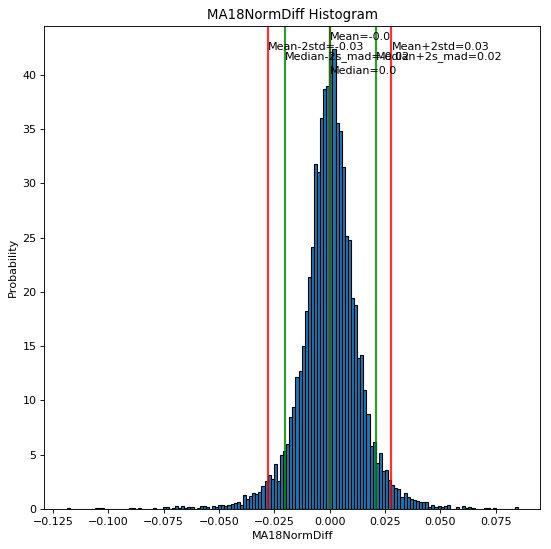

Column MA20NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  146
n=7687, q25=-0.01, q75=0.01, min=-0.12, max=0.09, interval length=0.00. Number of intervals=146
Feature characteristics for MA20NormDiff:
Min value =  -0.12092608889639092
Max value =  0.08537410220582717
Mean =  -0.0
Median = 0.00023006620756338414
Standard deviation = 0.014
Skew = -0.485
kurtosis = 5.8056


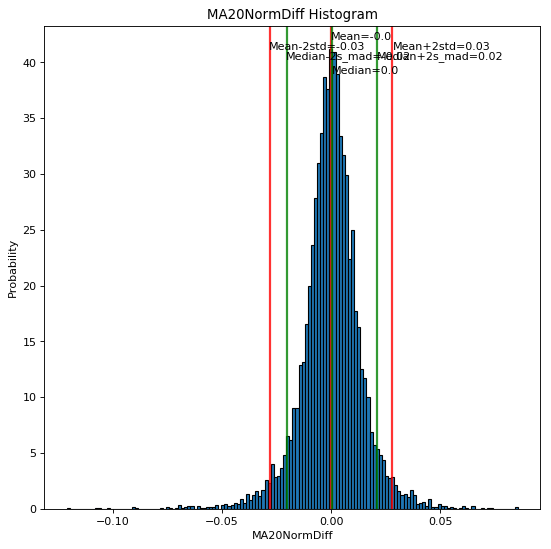

Column MA40NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  158
n=7687, q25=-0.01, q75=0.01, min=-0.13, max=0.09, interval length=0.00. Number of intervals=158
Feature characteristics for MA40NormDiff:
Min value =  -0.1319956565273233
Max value =  0.09355447059206047
Mean =  -0.0
Median = 9.259892160900716e-05
Standard deviation = 0.0143
Skew = -0.4415
kurtosis = 6.4671


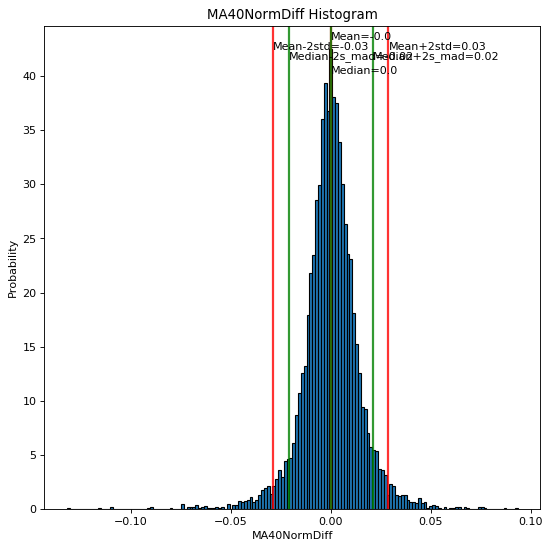

Column MA50NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  162
n=7687, q25=-0.01, q75=0.01, min=-0.14, max=0.09, interval length=0.00. Number of intervals=162
Feature characteristics for MA50NormDiff:
Min value =  -0.13691148265412198
Max value =  0.09337296535370262
Mean =  0.0
Median = 1.0018197139152753e-05
Standard deviation = 0.0145
Skew = -0.4479
kurtosis = 6.8417


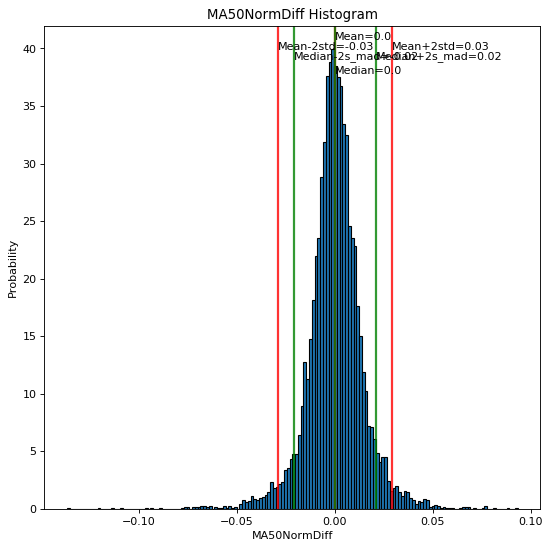

Column MA75NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  170
n=7687, q25=-0.01, q75=0.01, min=-0.14, max=0.10, interval length=0.00. Number of intervals=170
Feature characteristics for MA75NormDiff:
Min value =  -0.14494035166626434
Max value =  0.0970073928773045
Mean =  0.0
Median = -5.173796770736872e-05
Standard deviation = 0.0147
Skew = -0.4559
kurtosis = 7.6522


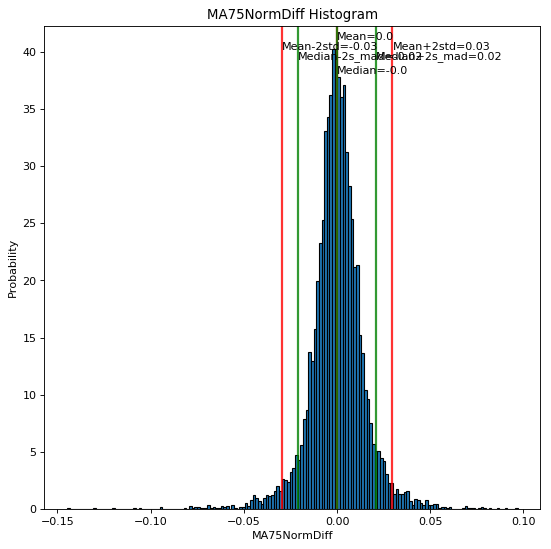

Column MA100NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  175
n=7687, q25=-0.01, q75=0.01, min=-0.15, max=0.10, interval length=0.00. Number of intervals=175
Feature characteristics for MA100NormDiff:
Min value =  -0.14712553970424555
Max value =  0.10143541012438342
Mean =  0.0
Median = -9.642432887553088e-05
Standard deviation = 0.0149
Skew = -0.457
kurtosis = 8.1619


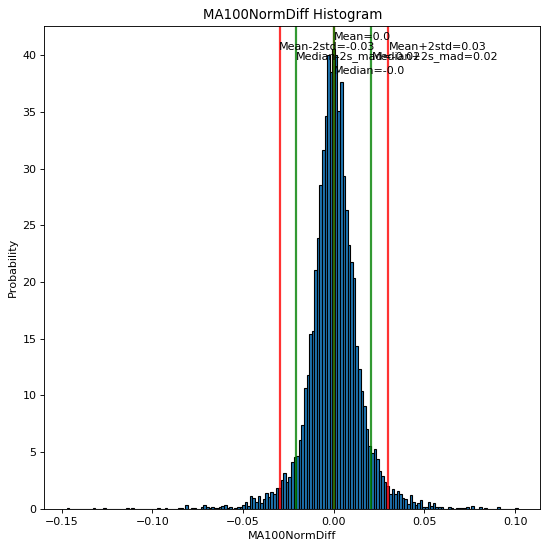

Column MA125NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  177
n=7687, q25=-0.01, q75=0.01, min=-0.15, max=0.10, interval length=0.00. Number of intervals=177
Feature characteristics for MA125NormDiff:
Min value =  -0.1479957782738029
Max value =  0.1019217665986858
Mean =  0.0
Median = -0.00011664957359841348
Standard deviation = 0.0151
Skew = -0.4597
kurtosis = 8.6091


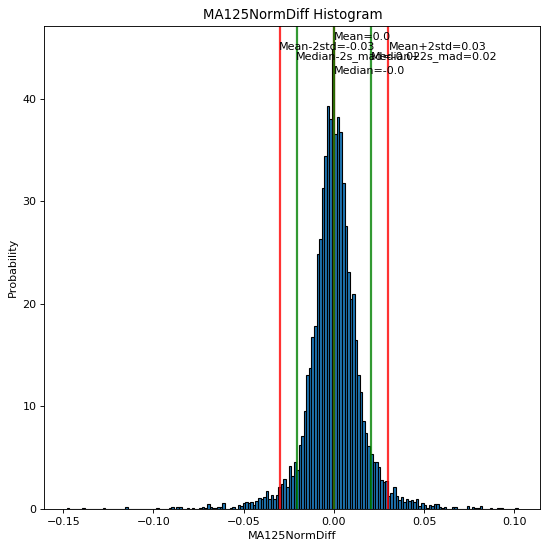

Column MA150NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  178
n=7687, q25=-0.01, q75=0.01, min=-0.15, max=0.10, interval length=0.00. Number of intervals=178
Feature characteristics for MA150NormDiff:
Min value =  -0.14683325117558332
Max value =  0.10354533668884094
Mean =  0.0
Median = -0.00014813610438552116
Standard deviation = 0.0152
Skew = -0.456
kurtosis = 8.979


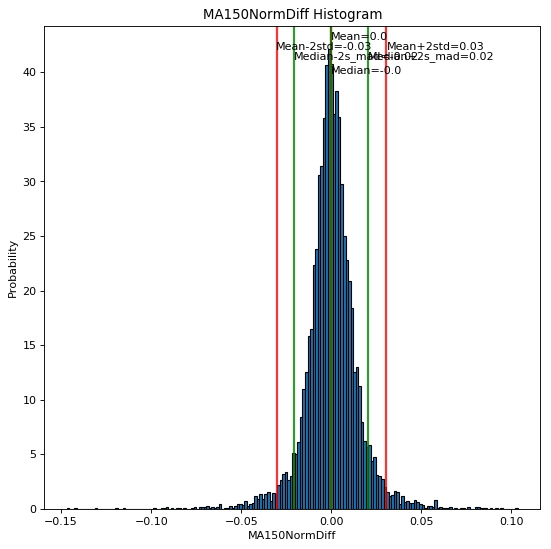

Column MA175NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  180
n=7687, q25=-0.01, q75=0.01, min=-0.14, max=0.11, interval length=0.00. Number of intervals=180
Feature characteristics for MA175NormDiff:
Min value =  -0.14433727245614153
Max value =  0.10751223591827803
Mean =  0.0
Median = -0.00015479581116031868
Standard deviation = 0.0153
Skew = -0.4415
kurtosis = 9.185


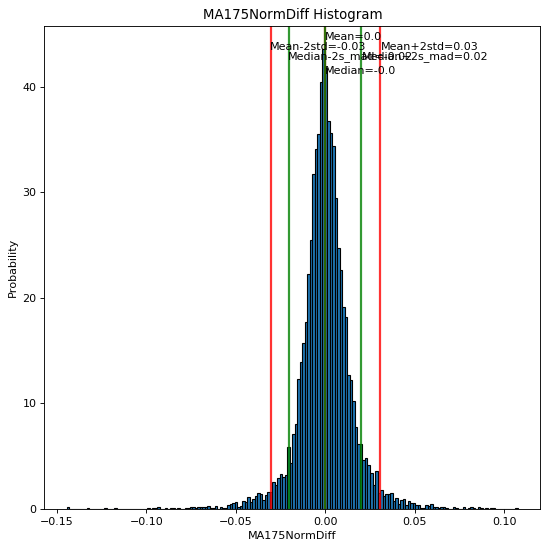

Column MA200NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  186
n=7687, q25=-0.01, q75=0.01, min=-0.15, max=0.11, interval length=0.00. Number of intervals=186
Feature characteristics for MA200NormDiff:
Min value =  -0.14588250084162865
Max value =  0.11060976849753146
Mean =  0.0
Median = -0.00017869857755326013
Standard deviation = 0.0154
Skew = -0.434
kurtosis = 9.3155


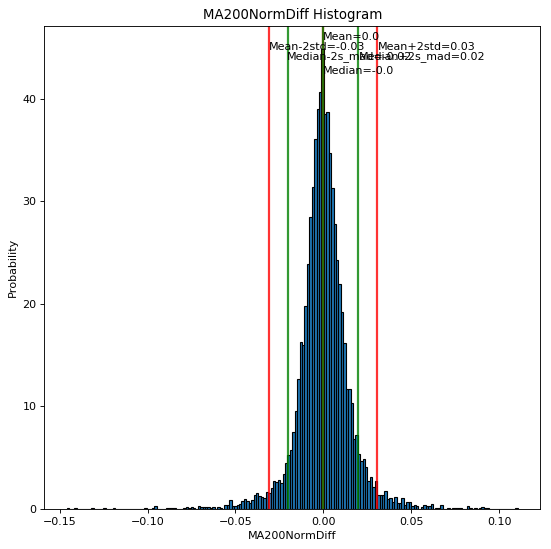

Column MA225NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  190
n=7687, q25=-0.01, q75=0.01, min=-0.15, max=0.11, interval length=0.00. Number of intervals=190
Feature characteristics for MA225NormDiff:
Min value =  -0.1481145364253938
Max value =  0.11366179601395825
Mean =  0.0
Median = -0.00016731860896600917
Standard deviation = 0.0154
Skew = -0.4362
kurtosis = 9.5051


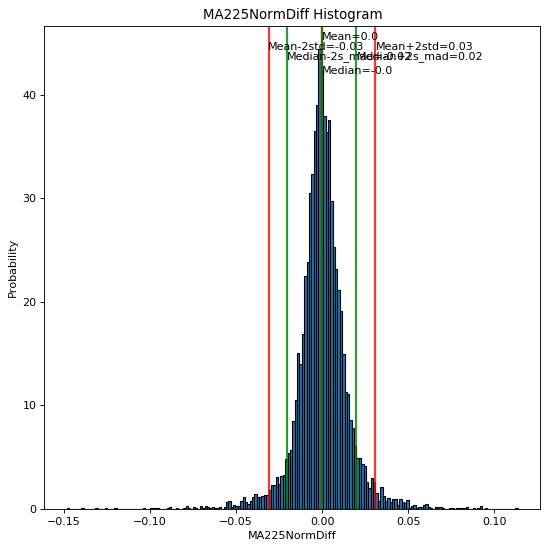

Column MA250NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  195
n=7687, q25=-0.01, q75=0.01, min=-0.15, max=0.12, interval length=0.00. Number of intervals=195
Feature characteristics for MA250NormDiff:
Min value =  -0.15159571387001994
Max value =  0.11620591886590065
Mean =  0.0
Median = -0.0001815846398883769
Standard deviation = 0.0155
Skew = -0.4457
kurtosis = 9.8538


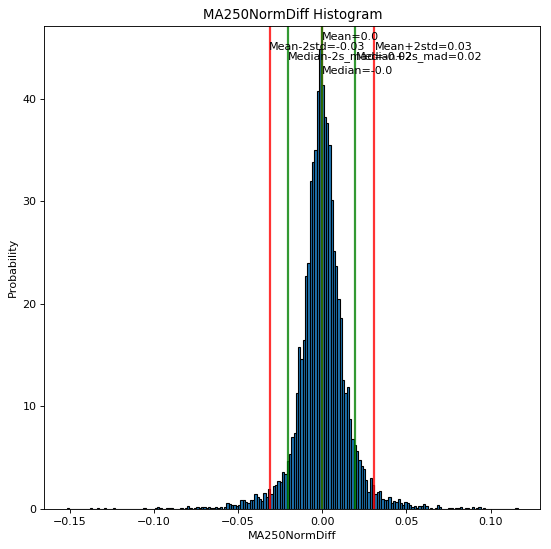

Column MA275NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  202
n=7687, q25=-0.01, q75=0.01, min=-0.16, max=0.12, interval length=0.00. Number of intervals=202
Feature characteristics for MA275NormDiff:
Min value =  -0.15532175397531822
Max value =  0.12021147393462868
Mean =  0.0
Median = -0.00019297255110173328
Standard deviation = 0.0156
Skew = -0.4482
kurtosis = 10.2068


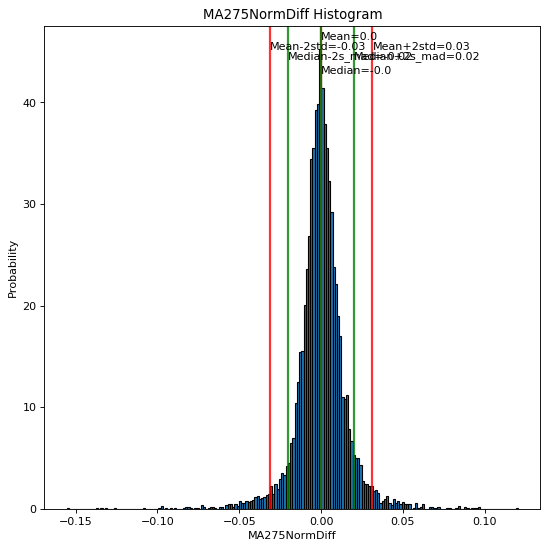

Column MA300NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  208
n=7687, q25=-0.01, q75=0.01, min=-0.16, max=0.12, interval length=0.00. Number of intervals=208
Feature characteristics for MA300NormDiff:
Min value =  -0.15929746477209872
Max value =  0.1236838971084992
Mean =  0.0
Median = -0.00016450017570572226
Standard deviation = 0.0157
Skew = -0.4577
kurtosis = 10.6596


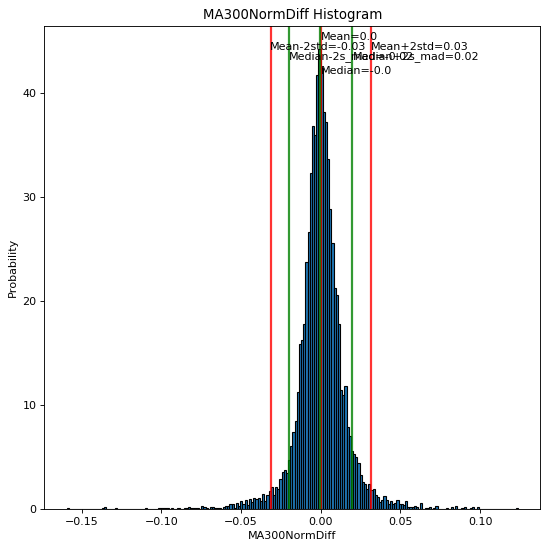

Column MA325NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  214
n=7687, q25=-0.01, q75=0.01, min=-0.16, max=0.13, interval length=0.00. Number of intervals=214
Feature characteristics for MA325NormDiff:
Min value =  -0.16237949961261675
Max value =  0.12697536709257906
Mean =  0.0
Median = -0.0002007805524457916
Standard deviation = 0.0158
Skew = -0.4592
kurtosis = 11.0318


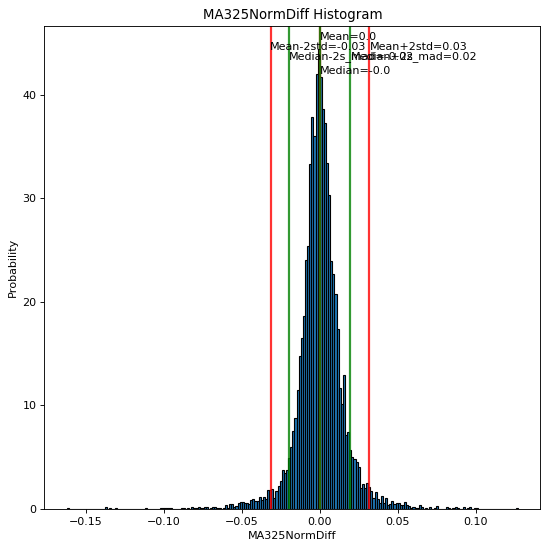

Column MA350NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  220
n=7687, q25=-0.01, q75=0.01, min=-0.17, max=0.13, interval length=0.00. Number of intervals=220
Feature characteristics for MA350NormDiff:
Min value =  -0.16603585612469166
Max value =  0.12986409616907096
Mean =  0.0
Median = -0.00017175111633085938
Standard deviation = 0.0158
Skew = -0.4682
kurtosis = 11.4444


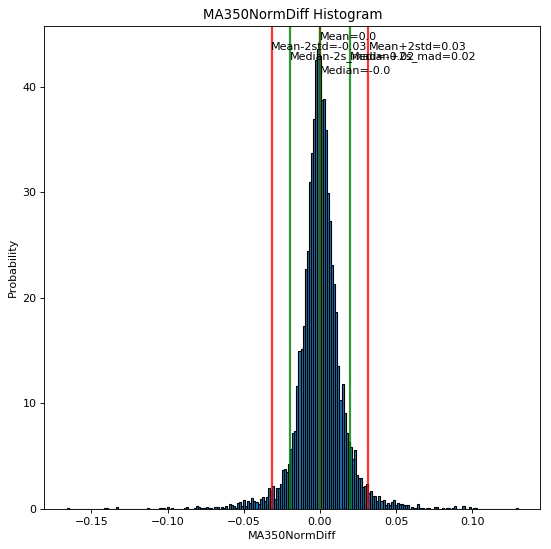

Column MA375NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  225
n=7687, q25=-0.01, q75=0.01, min=-0.17, max=0.13, interval length=0.00. Number of intervals=225
Feature characteristics for MA375NormDiff:
Min value =  -0.1688352345731915
Max value =  0.13201261336758952
Mean =  0.0
Median = -0.00017670100817609308
Standard deviation = 0.0159
Skew = -0.473
kurtosis = 11.8154


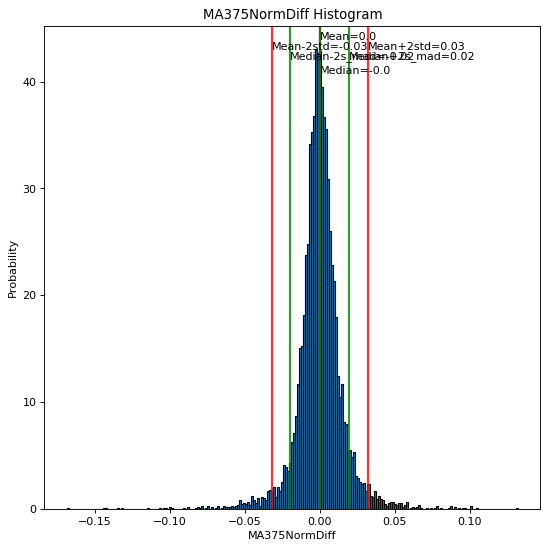

Column MA400NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  230
n=7687, q25=-0.01, q75=0.01, min=-0.17, max=0.13, interval length=0.00. Number of intervals=230
Feature characteristics for MA400NormDiff:
Min value =  -0.17126792621653386
Max value =  0.13494158740196793
Mean =  0.0
Median = -0.000209220980054034
Standard deviation = 0.0159
Skew = -0.4751
kurtosis = 12.1676


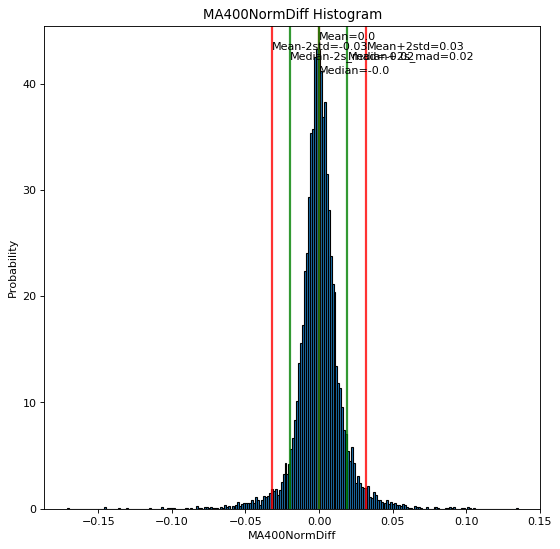

Column RSI2 is a numerical value
Number of unique features 7671 
Number of bins with Freedman und Diaconis:  17
n=7687, q25=24.21, q75=83.53, min=0.01, max=99.99, interval length=6.01. Number of intervals=17
Feature characteristics for RSI2:
Min value =  0.008837094541702496
Max value =  99.99192461593552
Mean =  53.85
Median = 57.15671368467896
Standard deviation = 31.6885
Skew = -0.1667
kurtosis = -1.3464


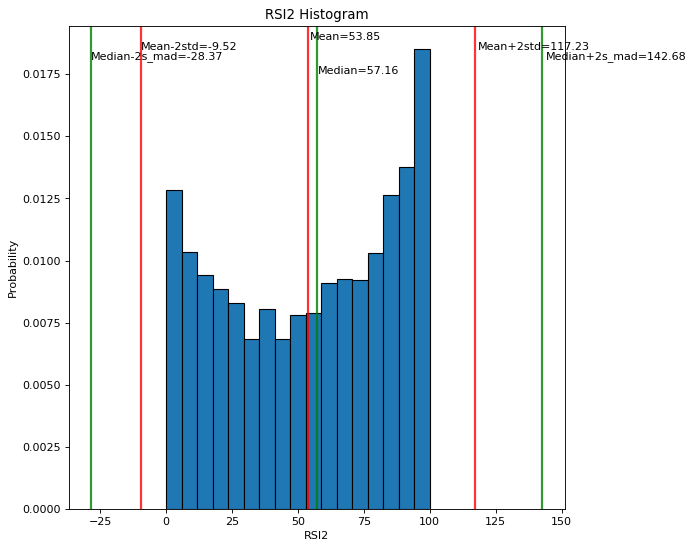

Column RSI5 is a numerical value
Number of unique features 7677 
Number of bins with Freedman und Diaconis:  31
n=7687, q25=38.78, q75=69.79, min=1.34, max=97.67, interval length=3.14. Number of intervals=31
Feature characteristics for RSI5:
Min value =  1.3420248809317057
Max value =  97.66800793564396
Mean =  53.82
Median = 54.896361194729536
Standard deviation = 20.2981
Skew = -0.1605
kurtosis = -0.7463


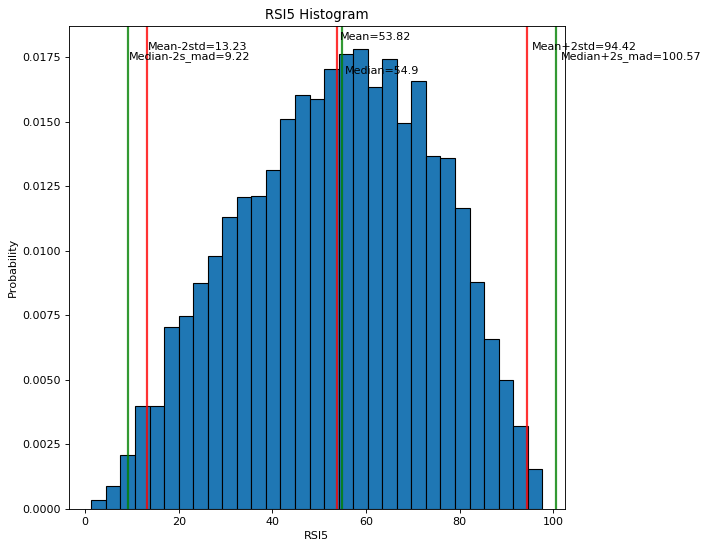

Column RSI14 is a numerical value
Number of unique features 7675 
Number of bins with Freedman und Diaconis:  42
n=7687, q25=44.43, q75=62.37, min=11.39, max=87.74, interval length=1.82. Number of intervals=42
Feature characteristics for RSI14:
Min value =  11.3910038871705
Max value =  87.74390754649792
Mean =  53.37
Median = 53.874426180978354
Standard deviation = 12.4306
Skew = -0.1132
kurtosis = -0.3577


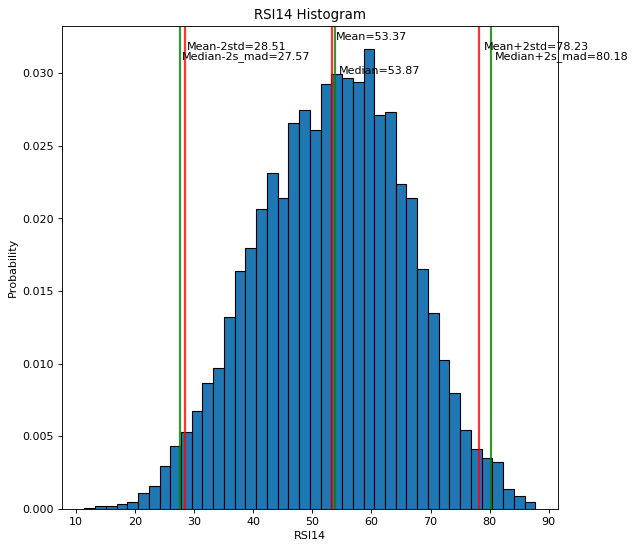

Column RSI20 is a numerical value
Number of unique features 7678 
Number of bins with Freedman und Diaconis:  46
n=7687, q25=45.82, q75=60.56, min=16.04, max=84.65, interval length=1.49. Number of intervals=46
Feature characteristics for RSI20:
Min value =  16.039556149763506
Max value =  84.65211025807436
Mean =  53.21
Median = 53.69664128834537
Standard deviation = 10.5657
Skew = -0.1018
kurtosis = -0.2725


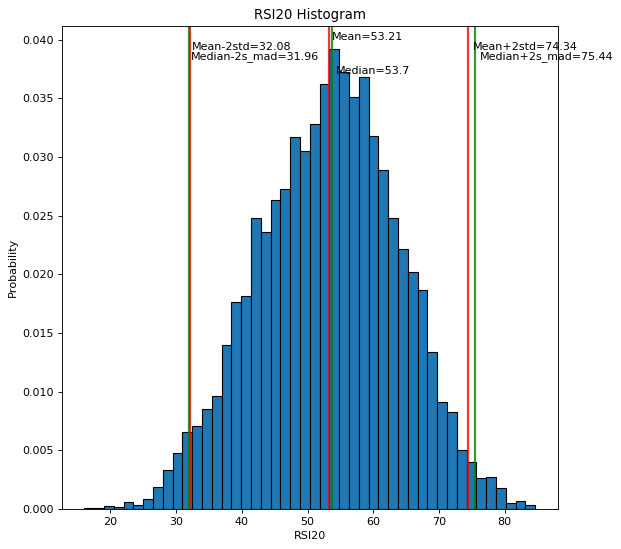

Column RSI25 is a numerical value
Number of unique features 7674 
Number of bins with Freedman und Diaconis:  48
n=7687, q25=46.53, q75=59.73, min=18.98, max=82.87, interval length=1.34. Number of intervals=48
Feature characteristics for RSI25:
Min value =  18.98358055733759
Max value =  82.87428334883086
Mean =  53.12
Median = 53.48864402363478
Standard deviation = 9.5672
Skew = -0.0991
kurtosis = -0.2381


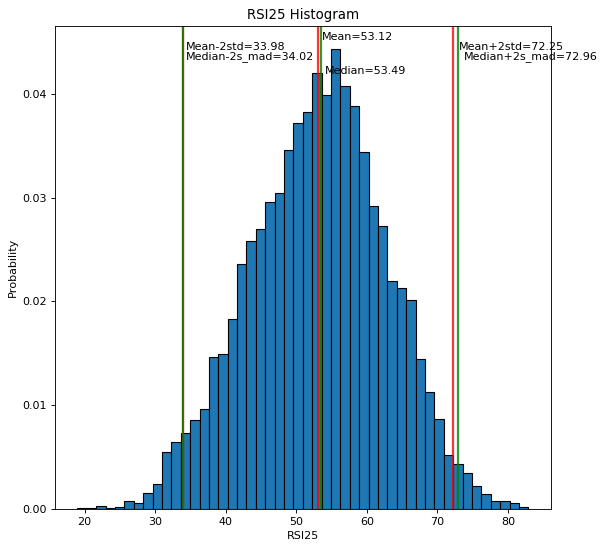

Column Stoch_slowk13 is a numerical value
Number of unique features 7165 
Number of bins with Freedman und Diaconis:  17
n=7687, q25=29.96, q75=87.31, min=-0.00, max=100.00, interval length=5.81. Number of intervals=17
Feature characteristics for Stoch_slowk13:
Min value =  -1.3974007136615304e-13
Max value =  100.00000000000004
Mean =  58.37
Median = 63.93158050721832
Standard deviation = 31.2548
Skew = -0.3183
kurtosis = -1.2799


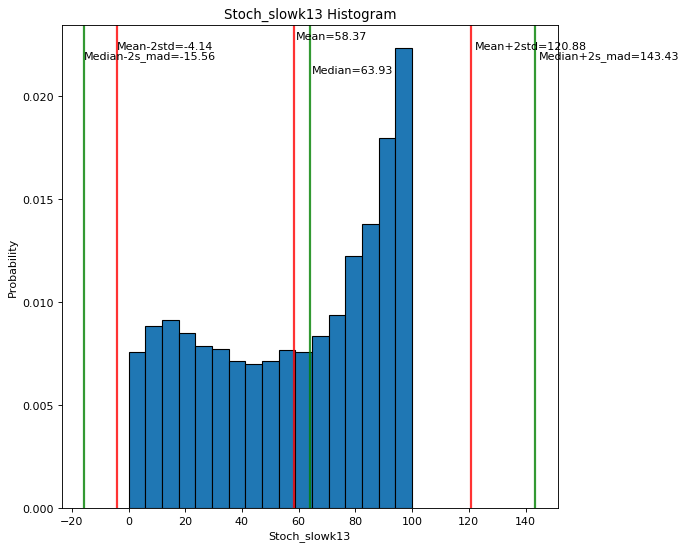

Column Stoch_slowd8 is a numerical value
Number of unique features 7651 
Number of bins with Freedman und Diaconis:  21
n=7687, q25=35.13, q75=82.60, min=0.31, max=100.00, interval length=4.81. Number of intervals=21
Feature characteristics for Stoch_slowd8:
Min value =  0.31250000000002204
Max value =  100.0000000000001
Mean =  58.37
Median = 62.02573176729361
Standard deviation = 27.0272
Skew = -0.2934
kurtosis = -1.1478


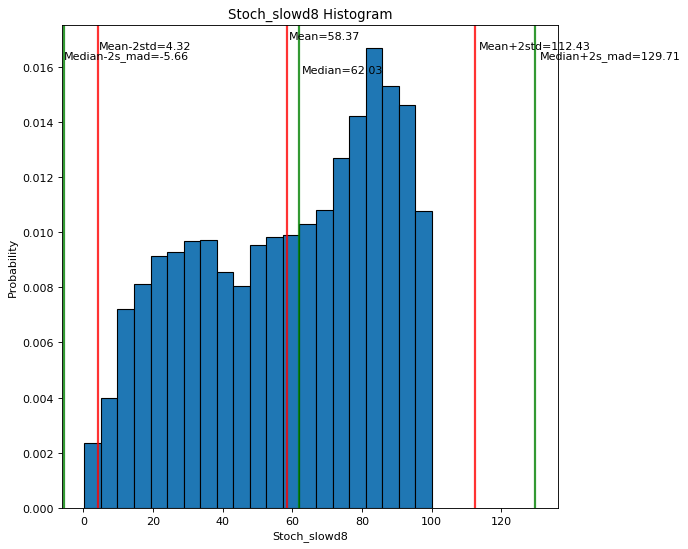

Column MACD12_26_9 is a numerical value
Number of unique features 7683 
Number of bins with Freedman und Diaconis:  89
n=7687, q25=-5.30, q75=10.49, min=-74.30, max=67.91, interval length=1.60. Number of intervals=89
Feature characteristics for MACD12_26_9:
Min value =  -74.29532051282342
Max value =  67.91070512820396
Mean =  1.25
Median = 2.3449999999963893
Standard deviation = 16.6327
Skew = -0.5839
kurtosis = 2.1439


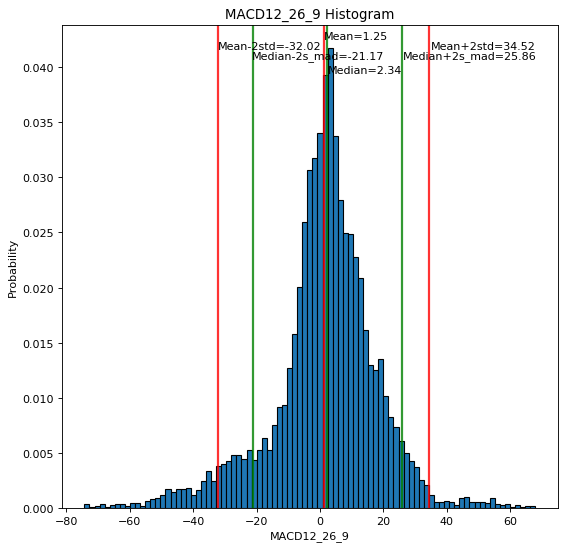

Column MACD12_26_9Diff is a numerical value
Number of unique features 7613 
Number of bins with Freedman und Diaconis:  138
n=7687, q25=-0.99, q75=0.93, min=-11.83, max=14.99, interval length=0.19. Number of intervals=138
Feature characteristics for MACD12_26_9Diff:
Min value =  -11.830128205128176
Max value =  14.987307692307468
Mean =  -0.0
Median = -0.04461538461532655
Standard deviation = 2.2692
Skew = 0.2534
kurtosis = 2.8616


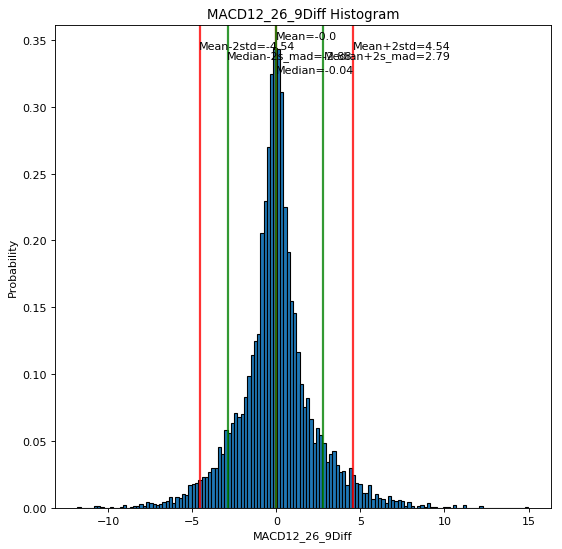

Column MACD12_26_9DiffDirChange is a numerical value
Number of unique features 11 
Number of bins = number of features {}:  11
n=7687, q25=-0.13, q75=0.13, min=-1.00, max=1.00, interval length=0.03. Number of intervals=11
Feature characteristics for MACD12_26_9DiffDirChange:
Min value =  -1.0
Max value =  1.0
Mean =  -0.0
Median = 0.0
Standard deviation = 0.466
Skew = 0.0064
kurtosis = 0.7263


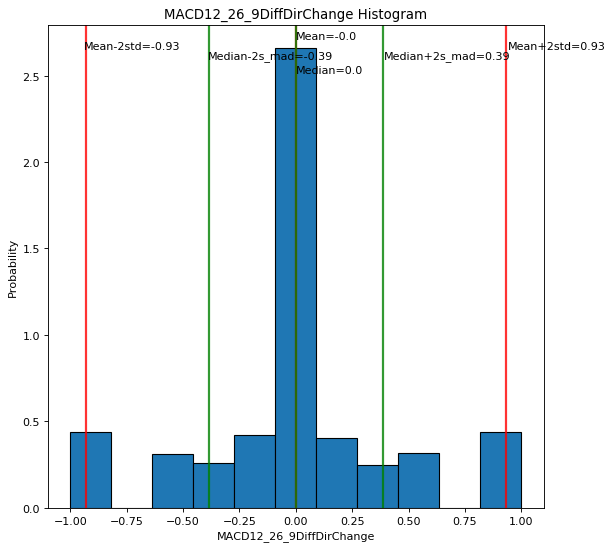

Column month_of_year is a numerical value
Number of unique features 12 
Number of bins = number of features {}:  12
n=7687, q25=4.00, q75=10.00, min=1.00, max=12.00, interval length=0.61. Number of intervals=12
Feature characteristics for month_of_year:
Min value =  1
Max value =  12
Mean =  6.56
Median = 7.0
Standard deviation = 3.4163
Skew = -0.049
kurtosis = -1.2013


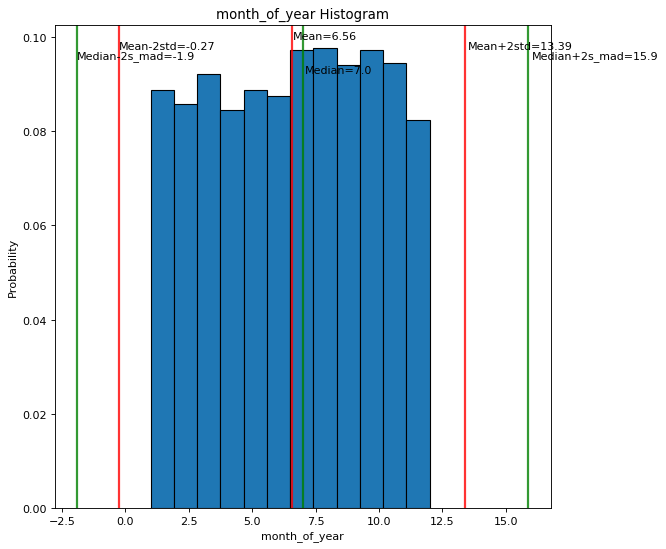

Column week_of_year is a numerical value
Number of unique features 53 
Number of bins with Freedman und Diaconis:  20
n=7687, q25=14.00, q75=40.00, min=1.00, max=53.00, interval length=2.63. Number of intervals=20
Feature characteristics for week_of_year:
Min value =  1
Max value =  53
Mean =  26.8
Median = 27.0
Standard deviation = 14.8757
Skew = -0.0434
kurtosis = -1.202


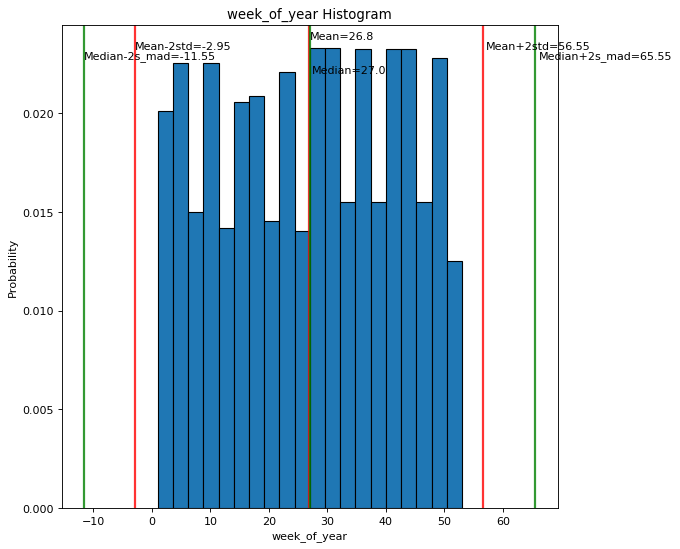

Column day_of_year is a numerical value
Number of unique features 362 
Number of bins with Freedman und Diaconis:  20
n=7687, q25=93.00, q75=274.00, min=2.00, max=365.00, interval length=18.34. Number of intervals=20
Feature characteristics for day_of_year:
Min value =  2
Max value =  365
Mean =  184.25
Median = 188.0
Standard deviation = 104.1578
Skew = -0.0431
kurtosis = -1.2018


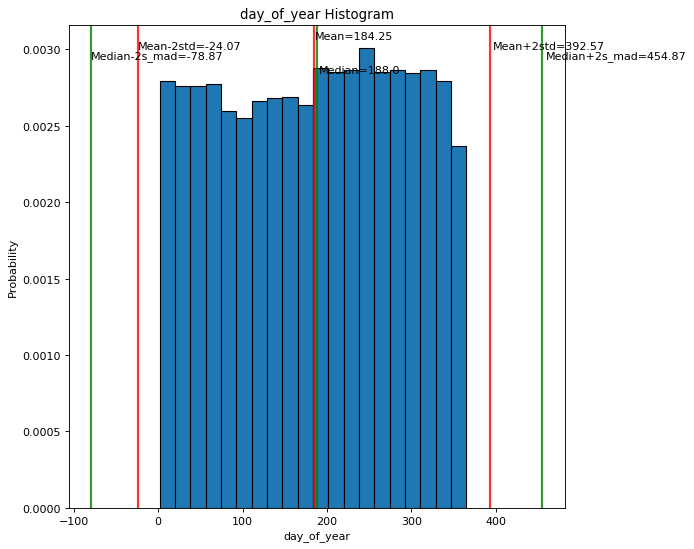

Column day_of_month is a numerical value
Number of unique features 31 
Number of bins with Freedman und Diaconis:  20
n=7687, q25=8.00, q75=23.00, min=1.00, max=31.00, interval length=1.52. Number of intervals=20
Feature characteristics for day_of_month:
Min value =  1
Max value =  31
Mean =  15.73
Median = 16.0
Standard deviation = 8.7327
Skew = 0.0191
kurtosis = -1.18


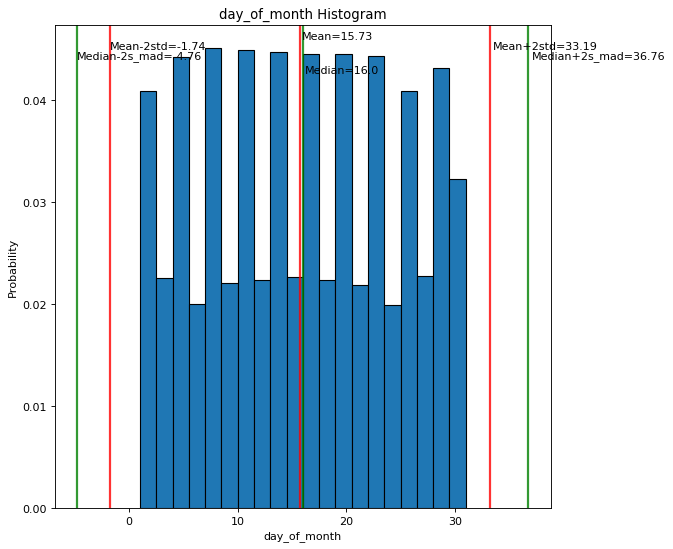

Column day_of_week is a numerical value
Number of unique features 7 
Number of bins = number of features {}:  7
n=7687, q25=1.00, q75=3.00, min=0.00, max=6.00, interval length=0.20. Number of intervals=7
Feature characteristics for day_of_week:
Min value =  0
Max value =  6
Mean =  2.0
Median = 2.0
Standard deviation = 1.4064
Skew = 0.0102
kurtosis = -1.2789


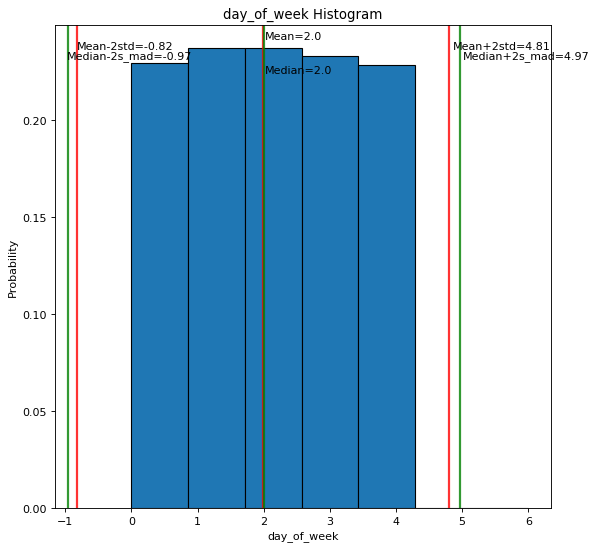

Column LongTrend is a numerical value
Number of unique features 2 
Number of bins = number of features {}:  2
n=7687, q25=0.00, q75=1.00, min=0.00, max=1.00, interval length=0.10. Number of intervals=2
Feature characteristics for LongTrend:
Min value =  0
Max value =  1
Mean =  0.67
Median = 1.0
Standard deviation = 0.4703
Skew = -0.7224
kurtosis = -1.4785


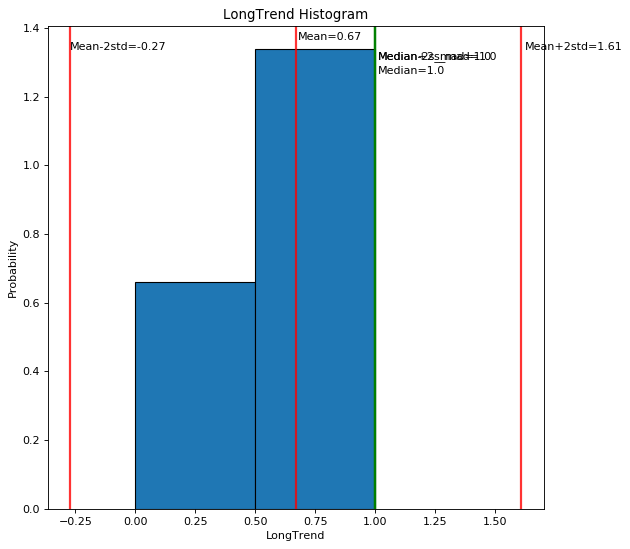

In [18]:
%%skip $skip_feature_analysis
save_graphs = False   #If set true, then all images are saved into the image save directory.

# Print graphs for all features
for i, d in enumerate(df.dtypes):
    if is_string_dtype(d):
        print("Column {} is a categorical string".format(df.columns[i]))
        source = df[df.columns[i]].value_counts()/numSamples
        fig = vis.paintBarChartForCategorical(source.index, source)
    else:
        print("Column {} is a numerical value".format(df.columns[i]))
        fig = vis.paintHistogram(df, df.columns[i])
    
    plt.figure(fig.number)
    if save_graphs == True:
        plt.savefig(image_save_directory + '/{}-{}'.format(i, df.columns[i]), dpi=300)
    plt.show()


In [19]:
#Optional Visualize all numeric values as melted
#melted = pd.melt(df, id_vars=[class_Name], value_name="MergedValues")
#melted['MergedValues'].describe()

#%matplotlib inline
#plt.figure(figsize=(12, 4))
#plt.hist(melted['MergedValues'], bins=list(range(0, 500)), log=True)
#plt.xlabel('Value')
#plt.ylabel('Count (log)')
#plt.title("Histogram of Features")
#plt.show()

In [20]:
#Visualize only the class to see if it is skewed
#vis.paintBarChartForCategorical(df[class_Name].value_counts().index, df[class_Name].value_counts())

### Feature Correlation Matrix

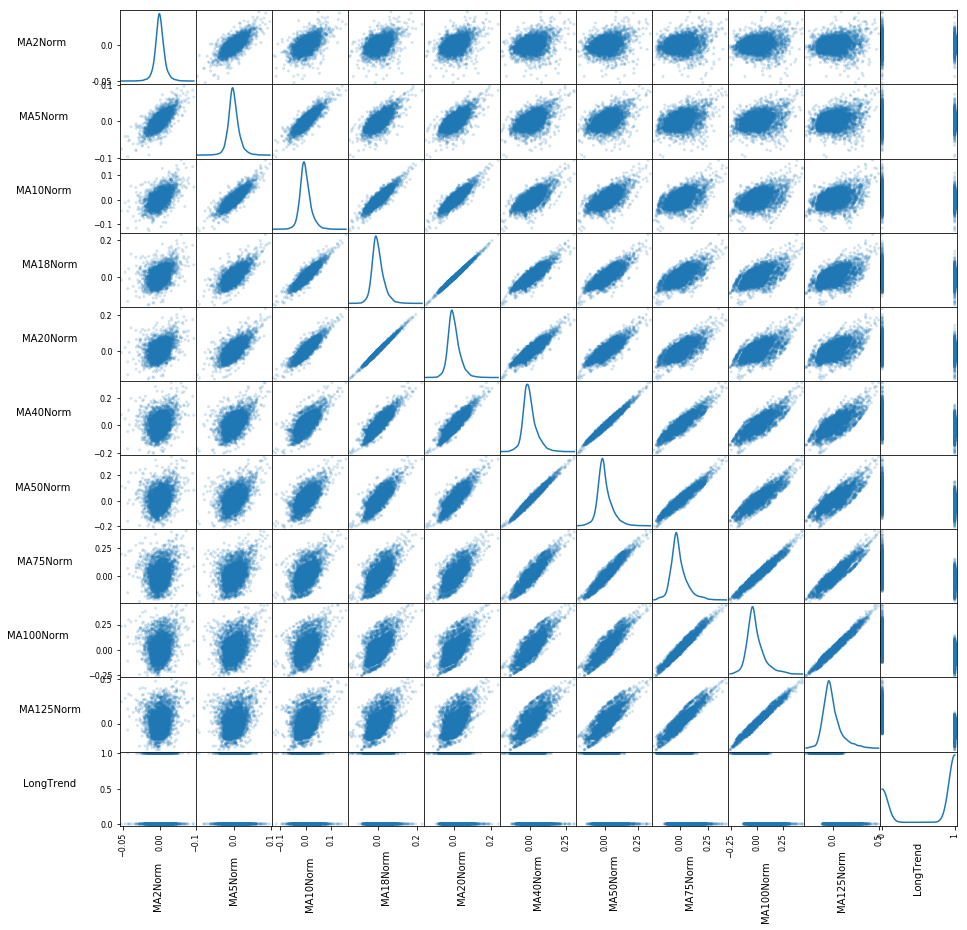

In [21]:
%%skip $skip_feature_analysis
#http://benalexkeen.com/correlation-in-python/
#https://stackoverflow.com/questions/26975089/making-the-labels-of-the-scatterplot-vertical-and-horizontal-in-pandas
from matplotlib.artist import setp

feature_plot=list(range(0,10,1))
feature_plot.extend([-1])
axs = pd.plotting.scatter_matrix(df.iloc[:,feature_plot], figsize=(15, 15), alpha=0.2, diagonal='kde')
n = len(df.iloc[:,feature_plot].columns)
for i in range(n):
    for j in range(n):
        # to get the axis of subplots
        ax = axs[i, j]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50
#plt.yticks(rotation=90)
plt.show()

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


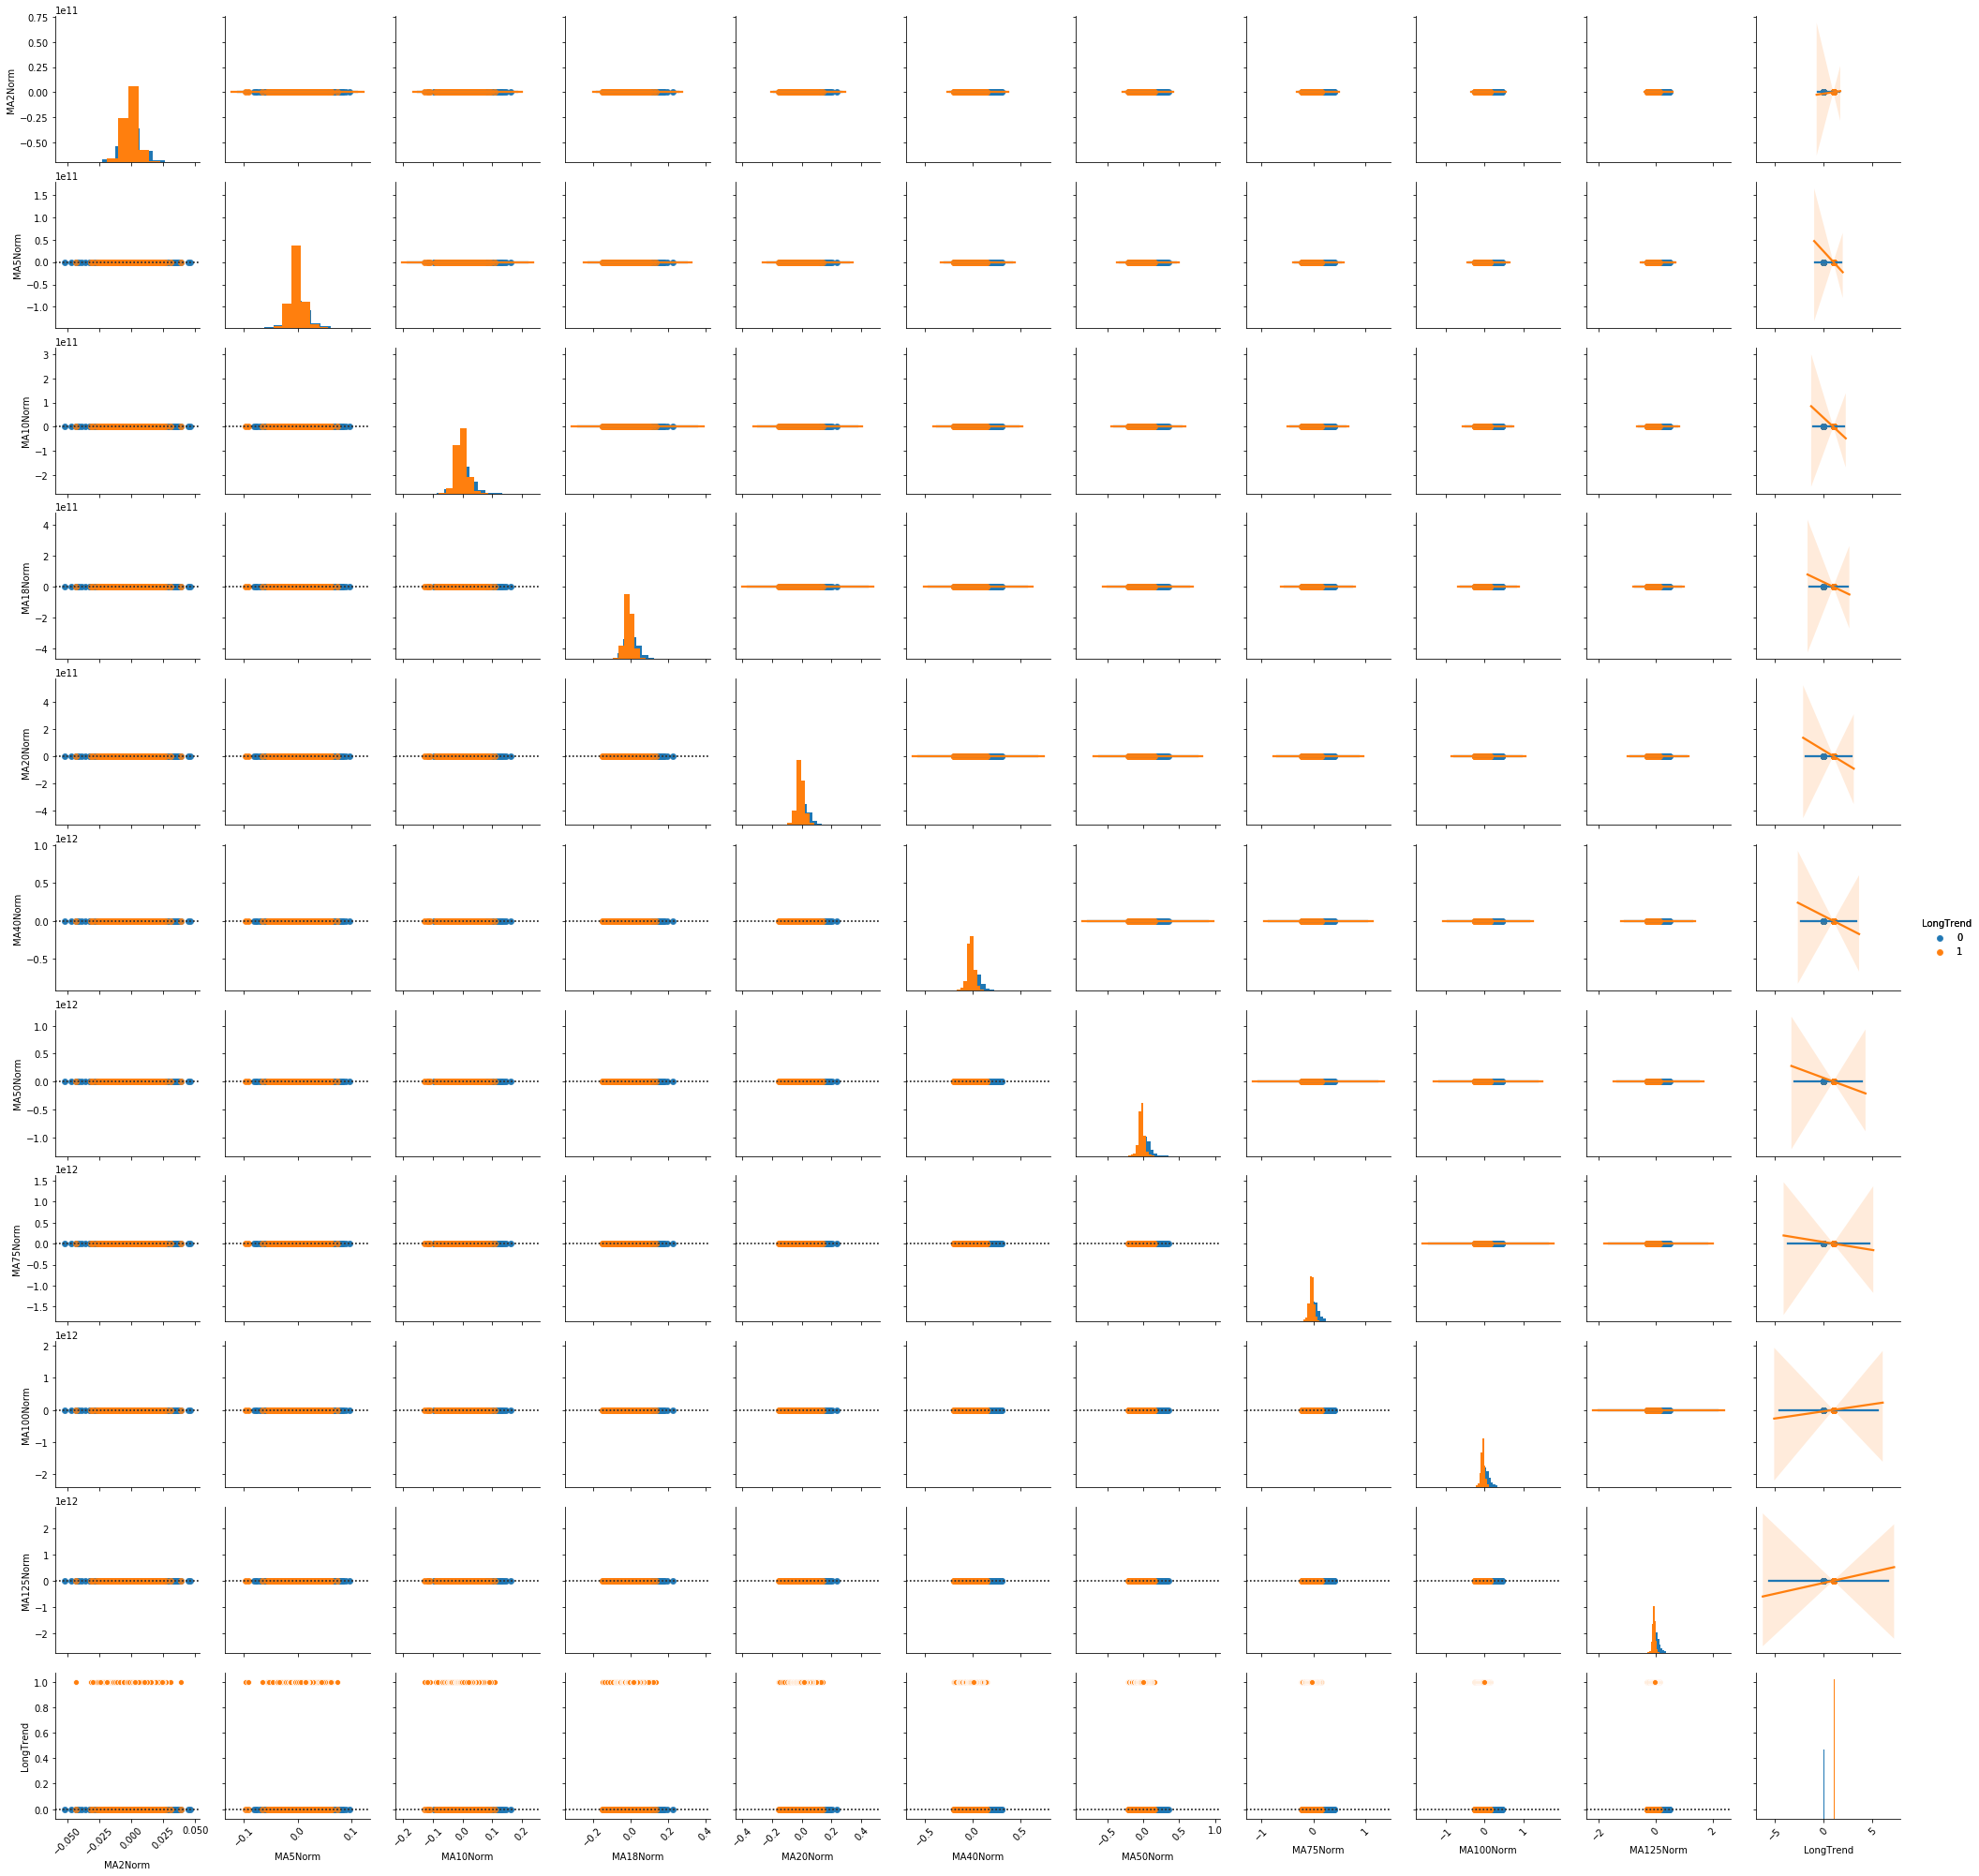

In [22]:
%%skip $skip_feature_analysis
import seaborn as sns

# https://blog.insightdatascience.com/data-visualization-in-python-advanced-functionality-in-seaborn-20d217f1a9a6

feature_plot=list(range(0,10,1))
feature_plot.extend([-1])

g = sns.pairplot(df.iloc[:,feature_plot], hue=df.columns[-1], diag_kind="hist") 
g.map_upper(sns.regplot) 
g.map_lower(sns.residplot) 
g.map_diag(plt.hist) 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45) 
g.add_legend() 
g.set(alpha=0.5)

plt.show()

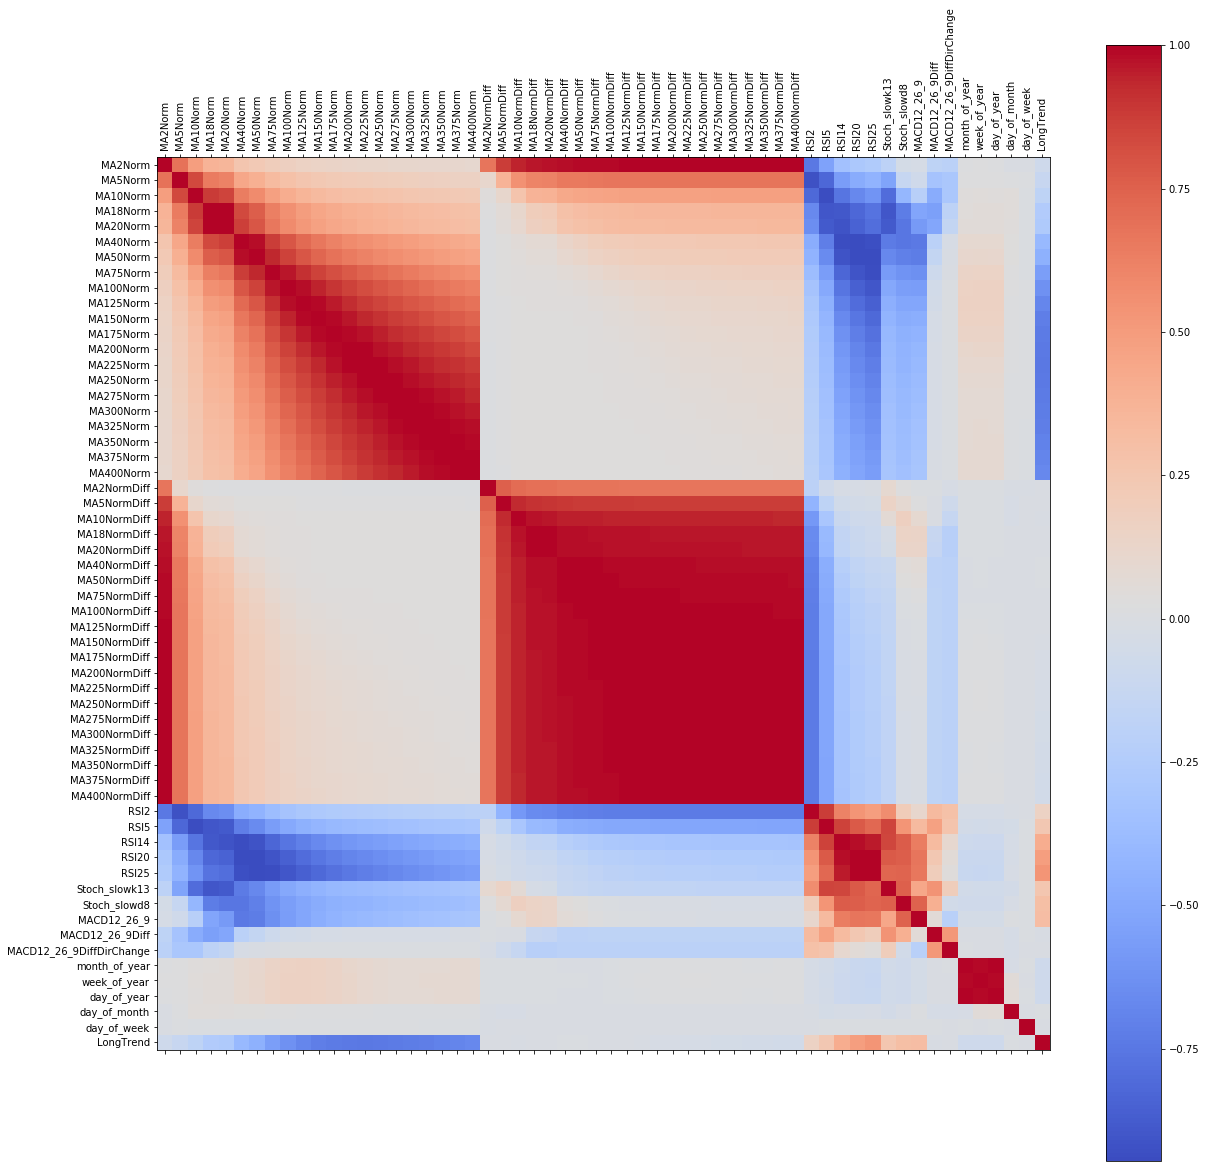

In [23]:
%%skip $skip_feature_analysis
#http://benalexkeen.com/correlation-in-python/
matfig = plt.figure(figsize=(20, 20))
plt.matshow(df.corr(method='spearman'), fignum=1, cmap=plt.get_cmap('coolwarm')) #Use spearman correlation instead of pearson to have a robust correlation
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.columns)), df.columns)
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

### Auto Correlations of Time Dependent Variables

Source: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

#### Autoregression Intuition

Consider a time series that was generated by an autoregression (AR) process with a lag of k. We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information. This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened. We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k. This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

#### Moving Average Intuition

Consider a time series that was generated by a moving average (MA) process with a lag of k. Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts. We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated. For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards. Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

if the autocorrelation function has a very long tail, then it is no stationary process

Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.


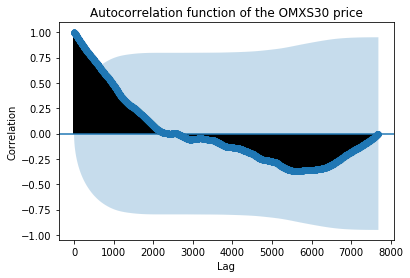

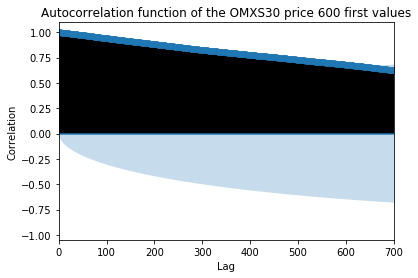

Ljung-Box statistics: p-value= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
If p values > 0.05 then there are significant autocorrelations.


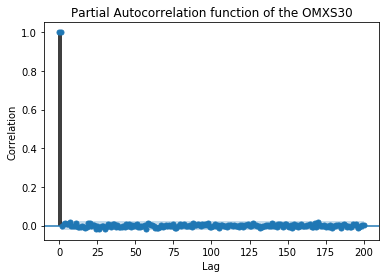

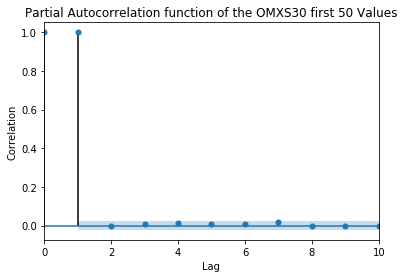

In [24]:
%%skip $skip_feature_analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

#Here, the time graph is selected
print("Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. "+
      "The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.")
plot_acf(np.log(df_timegraph['Close']))
plt.title("Autocorrelation function of the OMXS30 price")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

plot_acf(np.log(df_timegraph['Close']))
plt.title("Autocorrelation function of the OMXS30 price 600 first values")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,700])
plt.show()

print("Ljung-Box statistics: p-value=", acorr_ljungbox(np.log(df_timegraph['Close']), lags=None, boxpierce="Ljung-Box")[1])
print("If p values > 0.05 then there are significant autocorrelations.")

plot_pacf(np.log(df_timegraph['Close']), lags=200)
plt.title("Partial Autocorrelation function of the OMXS30")
plt.xlabel("Lag")
plt.ylabel("Correlation")
#plt.xlim([0,700])
plt.show()

plot_pacf(np.log(df_timegraph['Close']), lags=50)
plt.title("Partial Autocorrelation function of the OMXS30 first 50 Values")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,10])
plt.show()

Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.


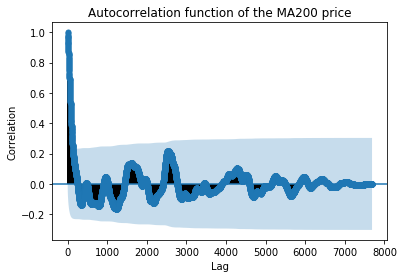

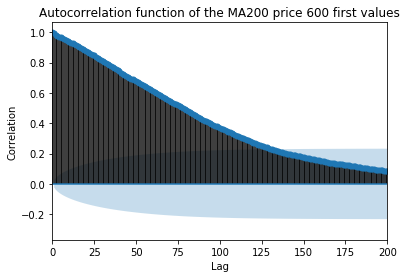

Ljung-Box statistics: p-value= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
If p values > 0.05 then there are significant autocorrelations.


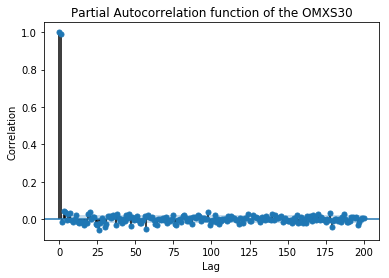

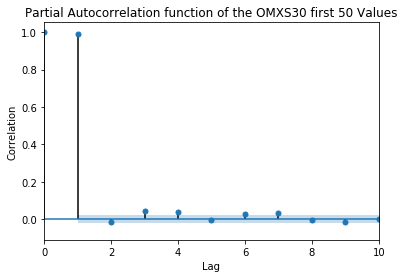

In [25]:
%%skip $skip_feature_analysis
#Here, the time graph is selected
print("Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. "+
      "The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.")
plot_acf(df.MA200Norm)
plt.title("Autocorrelation function of the MA200 price")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

plot_acf(df.MA200Norm)
plt.title("Autocorrelation function of the MA200 price 600 first values")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,200])
plt.show()

print("Ljung-Box statistics: p-value=", acorr_ljungbox(df.MA200Norm, lags=None, boxpierce="Ljung-Box")[1])
print("If p values > 0.05 then there are significant autocorrelations.")

plot_pacf(df.MA200Norm, lags=200)
plt.title("Partial Autocorrelation function of the OMXS30")
plt.xlabel("Lag")
plt.ylabel("Correlation")
#plt.xlim([0,700])
plt.show()

plot_pacf(df.MA200Norm, lags=50)
plt.title("Partial Autocorrelation function of the OMXS30 first 50 Values")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,10])
plt.show()

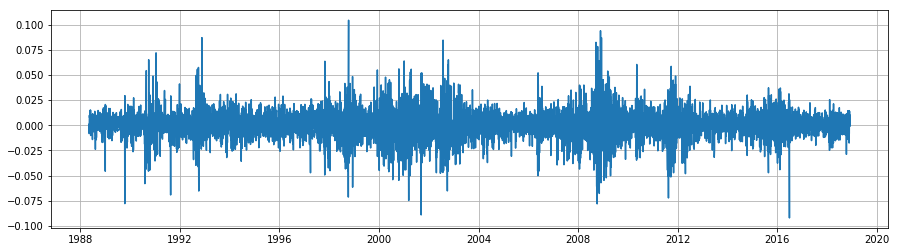

In [26]:
%%skip $skip_feature_analysis
#Plot difference between time values to see if the differences are stationary
diff = pd.DataFrame(data=np.divide(df_timegraph['Close'] - df_timegraph['Close'].shift(1), df_timegraph['Close'])).set_index(df_timegraph['Time'])
diff=diff.iloc[1:,:]
fig = plt.figure(figsize= (15, 4))
plt.plot(df_timegraph['Time'].iloc[1:], diff)
plt.grid()

Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.


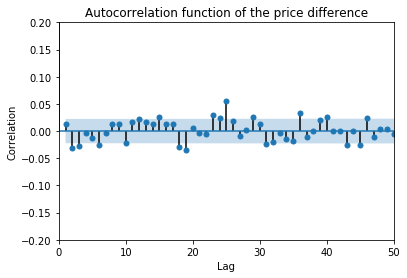

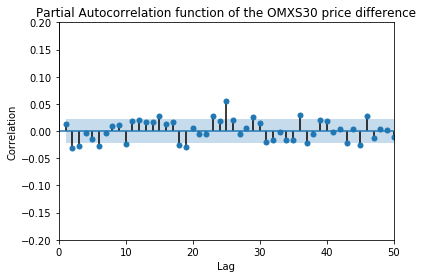

Ljung-Box statistics: p-value= [0.249 0.012 0.002 0.004 0.006 0.001 0.003 0.004 0.004 0.002 0.002 0.001
 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
If p values > 0.05 then there are significant autocorrelations.


In [27]:
%%skip $skip_feature_analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

#Here, the time graph is selected
print("Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. "+
      "The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.")

plot_acf(diff)
plt.title("Autocorrelation function of the price difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.ylim([-0.2, 0.2])
plt.xlim([0,50])
plt.show()

plot_pacf(diff, lags=100)
plt.title("Partial Autocorrelation function of the OMXS30 price difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,50])
plt.ylim([-0.2, 0.2])
plt.show()

print("Ljung-Box statistics: p-value=", acorr_ljungbox(diff, lags=None, boxpierce="Ljung-Box")[1])
print("If p values > 0.05 then there are significant autocorrelations.")

### Feature visualization with Parallel Coordinates

In [28]:
#Select a random subset to visualize
import random

#Reduce the training set with the number of samples randomly chosen
X_train_index_subset = sup.get_data_subset_index(1000, df)
df_fv = df.iloc[X_train_index_subset, :]

Cutting the data to  1000
Created a training subset


C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


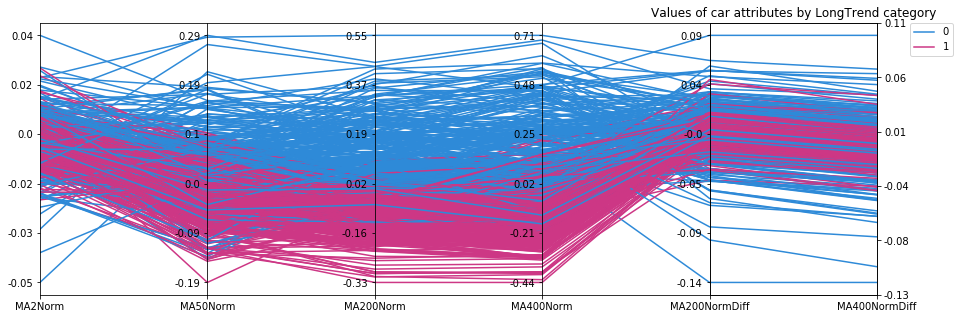

In [29]:
%%skip $skip_feature_analysis
# Use parallel coordinates to visualize the classes and all features for plotting
#https://plot.ly/python/parallel-coordinates-plot/
#http://benalexkeen.com/parallel-coordinates-in-matplotlib/
from matplotlib import ticker

def plotParallelCoordinates(df, cols, colours, comparison_name):
    x = [i for i, _ in enumerate(cols)]

    # create dict of categories: colours
    colours = {df[comparison_name].astype('category').cat.categories[i]: colours[i] 
               for i, _ in enumerate(df[comparison_name].astype('category').cat.categories)}

    # Create (X-1) sublots along x axis
    fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(15,5))

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for col in cols:
        min_max_range[col] = [df[col].min(), df[col].max(), np.ptp(df[col])]
        df[col] = np.true_divide(df[col] - df[col].min(), np.ptp(df[col]))

    # Plot each row
    for i, ax in enumerate(axes):
        for idx in df.index:
            mpg_category = df.loc[idx, comparison_name]
            ax.plot(x, df.loc[idx, cols], colours[mpg_category])
        ax.set_xlim([x[i], x[i+1]])
    
    # Set the tick positions and labels on y axis for each plot
    # Tick positions based on normalised data
    # Tick labels are based on original data
    def set_ticks_for_axis(dim, ax, ticks):
        min_val, max_val, val_range = min_max_range[cols[dim]]
        step = val_range / float(ticks-1)
        tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
        norm_min = df[cols[dim]].min()
        norm_range = np.ptp(df[cols[dim]])
        norm_step = norm_range / float(ticks-1)
        ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
        ax.yaxis.set_ticks(ticks)
        ax.set_yticklabels(tick_labels)

    for dim, ax in enumerate(axes):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        set_ticks_for_axis(dim, ax, ticks=6)
        ax.set_xticklabels([cols[dim]])
    

    # Move the final axis' ticks to the right-hand side
    ax = plt.twinx(axes[-1])
    dim = len(axes)
    ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([cols[-2], cols[-1]])

    # Remove space between subplots
    plt.subplots_adjust(wspace=0)

    # Add legend to plot
    plt.legend(
        [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in df[comparison_name].astype('category').cat.categories],
        df[comparison_name].astype('category').cat.categories,
        bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

    plt.title("Values of car attributes by LongTrend category")

    plt.show()


cols = ['MA2Norm', 'MA50Norm', 'MA200Norm', 'MA400Norm', 'MA200NormDiff', 'MA400NormDiff']
colors = ['#2e8ad8', '#cd3785', '#c64c00', '#889a00']
comparison_name = class_name

plotParallelCoordinates(df_fv, cols, colors, comparison_name)

## Prepare the Columns

In [30]:
#=== Replace signs for missing values or other values with ===#
df_dig = df.copy()

#Custom replacements, replace only if there is something to replace, else it makes NAN of it
#value_replacements = {
#    'n': 0,
#    'y': 1,
#    'unknown': np.NAN
#}

#=== Replace all custom values and missing values with content from the value_replacement
for col in df.columns[0:-1]:
    #df_dig[col] = df[col].map(value_replacements)
    #df_dig[col] = df[col].replace('?', np.nan)
    
    #Everything to numeric
    df_dig[col] = pd.to_numeric(df_dig[col])
    #df_dig[col] = np.int64(df_dig[col])
    
display(df_dig.head(5))

MA2Norm   MA5Norm  MA10Norm  MA18Norm  MA20Norm  MA40Norm  MA50Norm  \
id                                                                          
400 -0.000887  0.005474  0.007285  0.001049  0.004271  0.000715 -0.004780   
401 -0.000501  0.000770  0.005799 -0.001806  0.001748 -0.000528 -0.004575   
402  0.004116  0.004845  0.011539  0.006001  0.007862  0.007503  0.004591   
403  0.000466  0.004928  0.011324  0.007302  0.006661  0.007852  0.006122   
404 -0.004963 -0.004325  0.000777 -0.001364 -0.003247 -0.002343 -0.003141   

     MA75Norm  MA100Norm  MA125Norm    ...      Stoch_slowd8  MACD12_26_9  \
id                                     ...                                  
400 -0.025304  -0.062232  -0.085097    ...         61.244193     0.219936   
401 -0.024792  -0.061021  -0.084941    ...         59.987745     0.269872   
402 -0.015554  -0.051159  -0.076006    ...         56.906784     0.153141   
403 -0.013589  -0.048263  -0.073401    ...         52.430048    -0.017628   
404 -0.021981  -0.055662  -0.080685    ...         45.178497    -0.170321   

     MACD12_26_9Diff  MACD12_26_9DiffDirChange  month_of_year  week_of_year  \
id                                                                            
400         0.058205                      0.13              5            19   
401         0.049936                      0.00              5            19   
402        -0.116731                     -1.00              5            19   
403        -0.170769                     -0.60              5            19   
404        -0.152692                     -0.36              5            20   

     day_of_year  day_of_month  day_of_week  LongTrend  
id                                                      
400          130             9            0          1  
401          131            10            1          1  
402          132            11            2          1  
403          134            13            4          1  
404          137            16            0          1  

[5 rows x 58 columns]

In [31]:
#Create one-hot-encoding for certain classes and replace the original class
#onehotlabels = pd.get_dummies(df_dig.iloc[:,1])

#Add one-hot-encondig columns to the dataset
#for i, name in enumerate(onehotlabels.columns):
#    df_dig.insert(i+1, column='Cylinder' + str(name), value=onehotlabels.loc[:,name])

#Remove the original columns
#df_dig.drop(columns=['cylinders'], inplace=True)

In [32]:
# Replace classes with digital values

#df_dig[class_name] = df[class_name].map(class_labels)
df_dig[class_name] = np.int64(df_dig[class_name])

display(df_dig[class_name].head(5))

id
400    1
401    1
402    1
403    1
404    1
Name: LongTrend, dtype: int64

## Determine Missing Data

In [33]:
# Check if there are any nulls in the data
print(df.isnull().values.sum())
df_dig[df_dig.isna().any(axis=1)]

0


Empty DataFrame
Columns: [MA2Norm, MA5Norm, MA10Norm, MA18Norm, MA20Norm, MA40Norm, MA50Norm, MA75Norm, MA100Norm, MA125Norm, MA150Norm, MA175Norm, MA200Norm, MA225Norm, MA250Norm, MA275Norm, MA300Norm, MA325Norm, MA350Norm, MA375Norm, MA400Norm, MA2NormDiff, MA5NormDiff, MA10NormDiff, MA18NormDiff, MA20NormDiff, MA40NormDiff, MA50NormDiff, MA75NormDiff, MA100NormDiff, MA125NormDiff, MA150NormDiff, MA175NormDiff, MA200NormDiff, MA225NormDiff, MA250NormDiff, MA275NormDiff, MA300NormDiff, MA325NormDiff, MA350NormDiff, MA375NormDiff, MA400NormDiff, RSI2, RSI5, RSI14, RSI20, RSI25, Stoch_slowk13, Stoch_slowd8, MACD12_26_9, MACD12_26_9Diff, MACD12_26_9DiffDirChange, month_of_year, week_of_year, day_of_year, day_of_month, day_of_week, LongTrend]
Index: []

[0 rows x 58 columns]

Number of missing values per feature


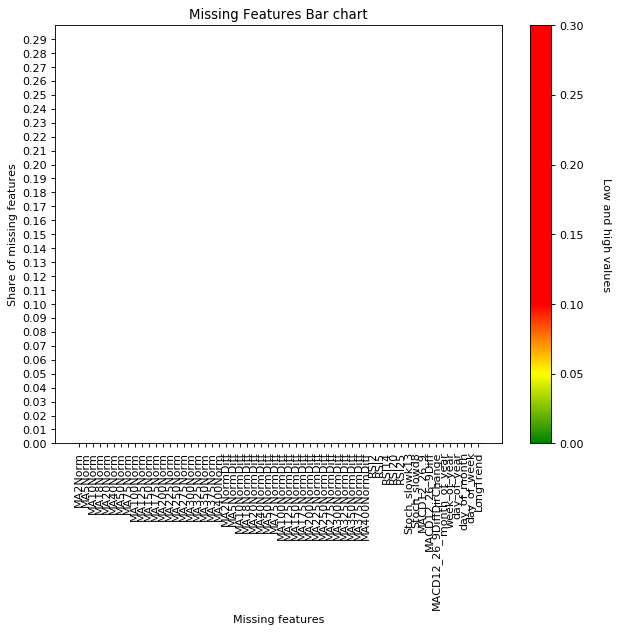

In [34]:
#Missing data part
print("Number of missing values per feature")
missingValueShare = []
for col in df_dig.columns:
    #if is_string_dtype(df_dig[col]):
    missingValueShare.append(sum(df_dig[col].isna())/numSamples)
        #print("Column {}: {}".format(col, round(sum(df[col]=='?')/numSamples, 3)))
    #else:
    #    missingValueShare.append(0)
        #print("Column {}: {}".format(col, 0))

#Print missing value graph
vis.paintBarChartForMissingValues(df_dig.columns, missingValueShare)

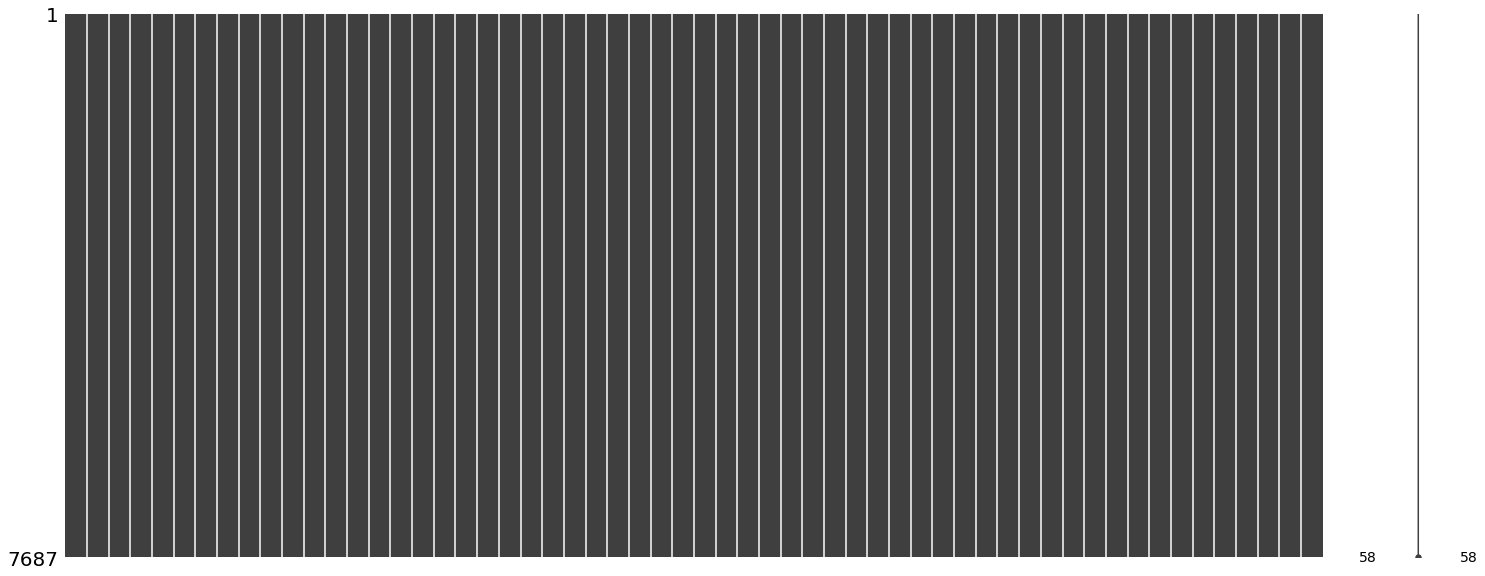

In [35]:
#Visualize missing data with missingno
import missingno as msno
%matplotlib inline
msno.matrix(df_dig)

In [36]:
if df.isnull().values.sum()>0:
    msno.heatmap(df_dig)

#### View Prepared Binary Features

We need some more plots for the binary data types.

In [37]:
#vis.plotBinaryValues(df_dig, df_dig.columns) #0:-1
#plt.savefig(image_save_directory + "/BinaryFeatures.png", dpi=70)

In [38]:
# Get feature data only
X_raw = df_dig.loc[:, df_dig.columns[0:-1]]

#X = df_raw.values[:,0:-1]
#X_labels = df_raw.columns[0:-1].values
#print("Original shape: {}, new shape without y values: {}".format(df_dig.values.shape, X.shape))
#print("X labels: {}".format(X.columns))
display(X_raw.head(2))

#y = df_raw.values[:,-1].reshape(-1, 1) #Important to do for the algorithms
y_raw = df_dig.loc[:, df_dig.columns[-1]]
y = y_raw.values.flatten()
#y_labels = class_labels
#class_labels_inverse = sup.inverse_dict(class_labels)

print("y shape: {}".format(y_raw.shape))
print("y labels: {}".format(class_labels))
print("y unique classes: {}".format(np.unique(y, axis=0)))

MA2Norm   MA5Norm  MA10Norm  MA18Norm  MA20Norm  MA40Norm  MA50Norm  \
id                                                                          
400 -0.000887  0.005474  0.007285  0.001049  0.004271  0.000715 -0.004780   
401 -0.000501  0.000770  0.005799 -0.001806  0.001748 -0.000528 -0.004575   

     MA75Norm  MA100Norm  MA125Norm     ...       Stoch_slowk13  Stoch_slowd8  \
id                                      ...                                     
400 -0.025304  -0.062232  -0.085097     ...           43.386788     61.244193   
401 -0.024792  -0.061021  -0.084941     ...           44.473501     59.987745   

     MACD12_26_9  MACD12_26_9Diff  MACD12_26_9DiffDirChange  month_of_year  \
id                                                                           
400     0.219936         0.058205                      0.13              5   
401     0.269872         0.049936                      0.00              5   

     week_of_year  day_of_year  day_of_month  day_of_week  
id                                                         
400            19          130             9            0  
401            19          131            10            1  

[2 rows x 57 columns]

y shape: (7687,)
y labels: {0: 'negative', 1: 'positive'}
y unique classes: [0 1]


# Feature Visualization
Here, feature selection and visulization of datasets is performed
Methods
- Feature visualization through t-SNE
- Feature visualization and analysis through PCA

## Normalize Data for Feature Selection
Z-Normalize the data around zero and divided by standard deviation. Fit the normalizer on the training data and transform the training and the test data. The reason is that the scaler only must depend on the training data, in order to prevent leakage of information from the test data.

In [39]:
from sklearn import preprocessing

#=== Select the best type of scaler ===#
scaler = preprocessing.StandardScaler() #Because normal distribution. Don't use minmax scaler for PCA or unsupervised learning
# as the axis shall be centered and not shifted.


scaler.fit(X_raw)
#Use this scaler also for the test data at the end
X_scaled = pd.DataFrame(data=scaler.transform(X_raw), index = X_raw.index, columns=X_raw.columns)
print("Unscaled values")
display(X_raw.iloc[0:2,:])
print("Scaled values")
display(X_scaled.iloc[0:2,:])

Unscaled values


MA2Norm   MA5Norm  MA10Norm  MA18Norm  MA20Norm  MA40Norm  MA50Norm  \
id                                                                          
400 -0.000887  0.005474  0.007285  0.001049  0.004271  0.000715 -0.004780   
401 -0.000501  0.000770  0.005799 -0.001806  0.001748 -0.000528 -0.004575   

     MA75Norm  MA100Norm  MA125Norm     ...       Stoch_slowk13  Stoch_slowd8  \
id                                      ...                                     
400 -0.025304  -0.062232  -0.085097     ...           43.386788     61.244193   
401 -0.024792  -0.061021  -0.084941     ...           44.473501     59.987745   

     MACD12_26_9  MACD12_26_9Diff  MACD12_26_9DiffDirChange  month_of_year  \
id                                                                           
400     0.219936         0.058205                      0.13              5   
401     0.269872         0.049936                      0.00              5   

     week_of_year  day_of_year  day_of_month  day_of_week  
id                                                         
400            19          130             9            0  
401            19          131            10            1  

[2 rows x 57 columns]

Scaled values


MA2Norm   MA5Norm  MA10Norm  MA18Norm  MA20Norm  MA40Norm  MA50Norm  \
id                                                                          
400 -0.110102  0.384970  0.360534  0.094432  0.191692  0.101728  0.011636   
401 -0.055313  0.078908  0.295959  0.004058  0.116492  0.076857  0.015233   

     MA75Norm  MA100Norm  MA125Norm     ...       Stoch_slowk13  Stoch_slowd8  \
id                                      ...                                     
400 -0.237136  -0.598227  -0.731228     ...           -0.479523      0.106226   
401 -0.230059  -0.584137  -0.729640     ...           -0.444751      0.059735   

     MACD12_26_9  MACD12_26_9Diff  MACD12_26_9DiffDirChange  month_of_year  \
id                                                                           
400    -0.061949         0.026642                  0.281213      -0.456603   
401    -0.058947         0.022998                  0.002196      -0.456603   

     week_of_year  day_of_year  day_of_month  day_of_week  
id                                                         
400     -0.524244    -0.520877      -0.77017    -1.418685  
401     -0.524244    -0.511276      -0.65565    -0.707585  

[2 rows x 57 columns]

### Visualize Data with t-SNE

In [40]:
%%skip $skip_feature_analysis
#Select a random subset to visualize
import random

#Reduce the training set with the number of samples randomly chosen
X_train_index_subset = sup.get_data_subset_index(1000, X_scaled)

Cutting the data to  1000
Created a training subset


In [41]:
%%skip $skip_feature_analysis
from sklearn.manifold import TSNE
#%matplotlib notebook
#%matplotlib inline

np.random.seed(0)
#X_embedded = TSNE(n_components=2, perplexity=5.0, early_exaggeration=12.0, n_iter=5000, 
#                  n_iter_without_progress=1000, learning_rate=10).fit_transform(embedded)
X_embedded = TSNE(n_components=2, perplexity=10.0, early_exaggeration=100.0, n_iter=5000, 
                  n_iter_without_progress=1000, learning_rate=10).fit_transform(X_scaled.iloc[X_train_index_subset,:])

#### Plot t-SNE with best parameters

In [42]:
%matplotlib inline

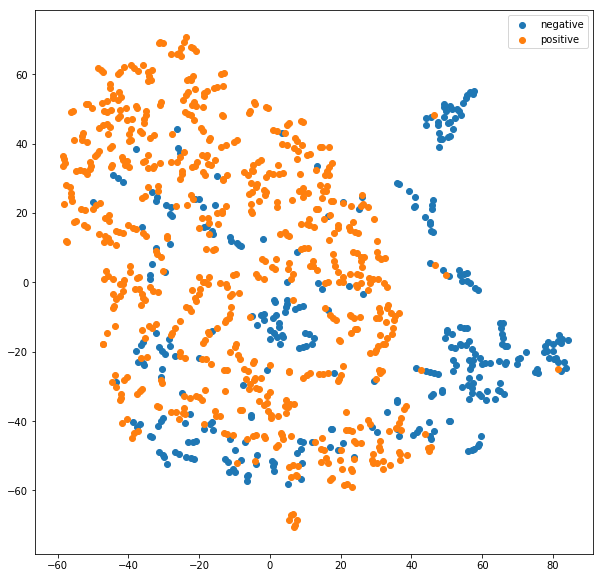

In [43]:
%%skip $skip_feature_analysis
#Plot with texts added to the graphs

#from adjustText import adjust_text
targets = np.array(y[X_train_index_subset]).flatten()

plt.figure(figsize=(10,10))
texts = []
for i, t in enumerate(set(targets)):
    idx = targets == t
    #for x, y in zip(X_embedded[idx, 0], X_embedded[idx, 1]):
        #texts.append(plt.text(x, y, t))
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=class_labels[t])   

#adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1,1), expand_text=(1,1), arrowprops=dict(arrowstyle="-", color='black', lw=0.5)) 

plt.legend(bbox_to_anchor=(1, 1));

#### t-SNE Parameter Grid Search

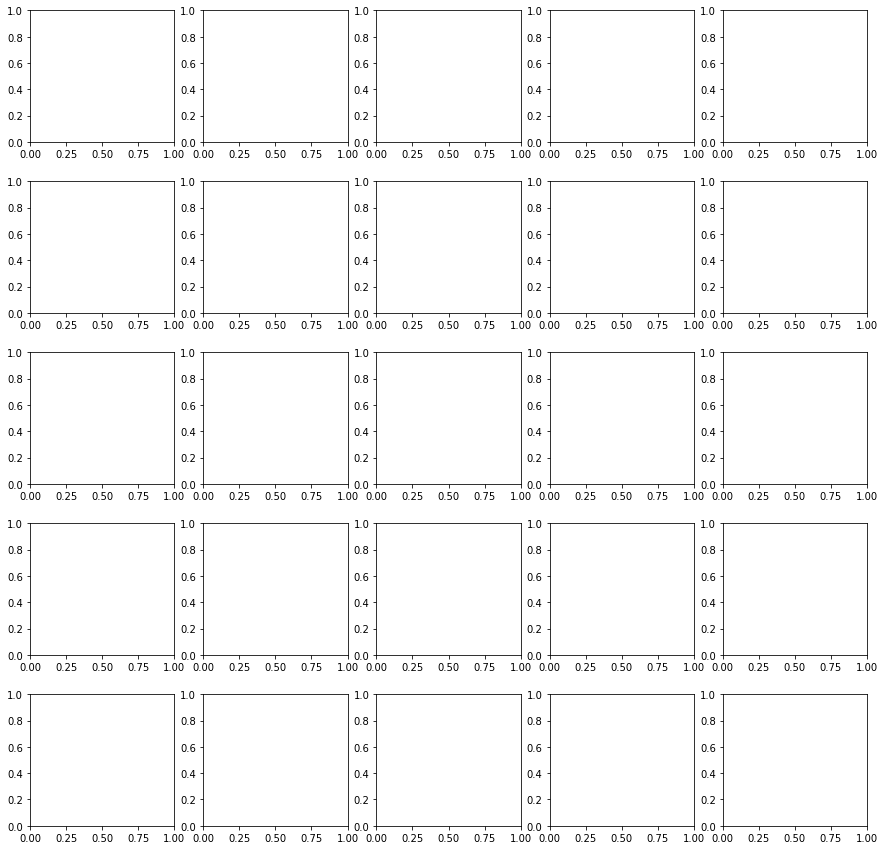

In [44]:
%%skip $skip_feature_analysis
from IPython.display import clear_output

#Optimize t-sne plot
tne_gridsearch = False

#Create a TSNE grid search with two variables
perplex = [5, 10, 30, 50, 100]
exaggregation = [5, 12, 20, 50, 100]
#learning_rate = [10, 50, 200]

fig, axarr = plt.subplots(len(perplex), len(exaggregation), figsize=(15,15))

if tne_gridsearch == True:
    #for m,l in enumerate(learning_rate):
    for k,p in enumerate(perplex):
        #print("i {}, p {}".format(i, p))
        for j,e in enumerate(exaggregation):
            #print("j {}, e {}".format(j, e))
            X_embedded = TSNE(n_components=2, perplexity=p, early_exaggeration=e, n_iter=5000, 
                              n_iter_without_progress=1000, learning_rate=10).fit_transform(X_scaled.iloc[X_train_index_subset,:])

            for i, t in enumerate(set(targets)):
                idx = targets == t
                axarr[k,j].scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=class_labels[t])

            axarr[k,j].set_title("p={}, e={}".format(p, e))
        
            clear_output(wait=True)
            print('perplex paramater={}/{}, exaggregation parameterj={}/{}'.format(k, len(perplex), j, len(exaggregation)))
        
fig.subplots_adjust(hspace=0.3)

### UMAP Cluster Analysis
Use a supervised/unsupervised analysis to make the clusters

In [45]:
%%skip $skip_feature_analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='poster')

import umap

#%time #Time of the whole cell
embeddingUnsupervised = umap.UMAP(n_neighbors=5).fit_transform(X_scaled)
#%time #Time of the whole cell
embeddingSupervised = umap.UMAP(n_neighbors=5).fit_transform(X_scaled, y=y)

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


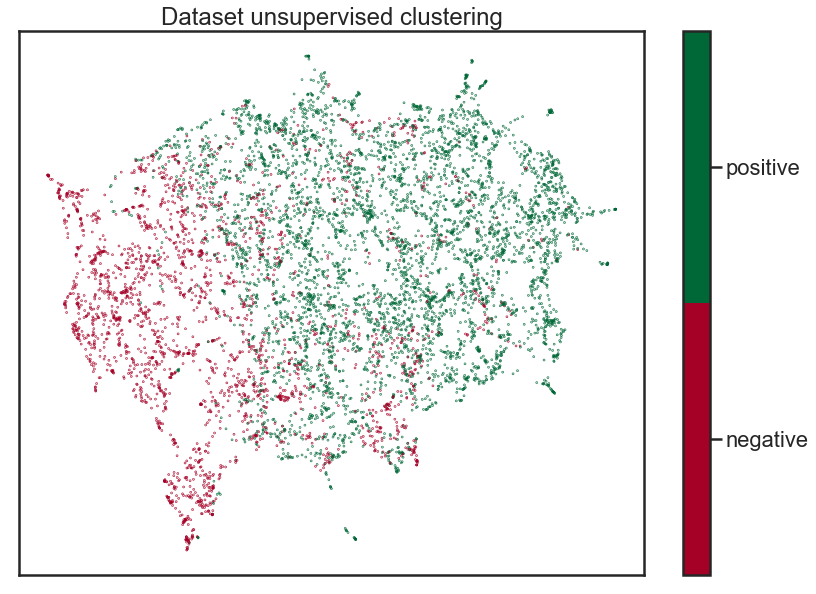

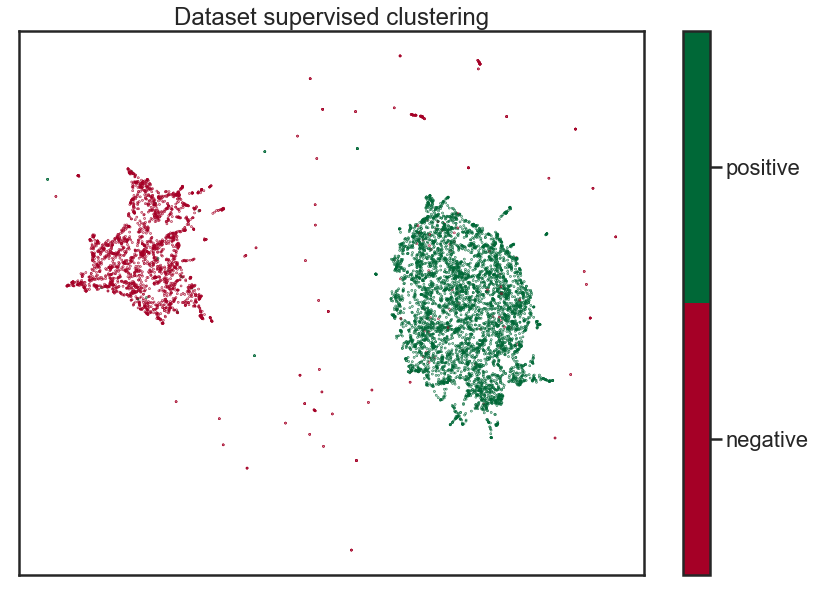

In [46]:
%%skip $skip_feature_analysis
vis.plotUmap(embeddingUnsupervised, y, list(class_labels.values()), 'Dataset unsupervised clustering', cmapString='RdYlGn')
vis.plotUmap(embeddingSupervised, y, list(class_labels.values()), 'Dataset supervised clustering')

### PCA Analysis

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log


95% variance covered with the 8 first components. Values=[0.425 0.717 0.804 0.856 0.887 0.906 0.923 0.941]


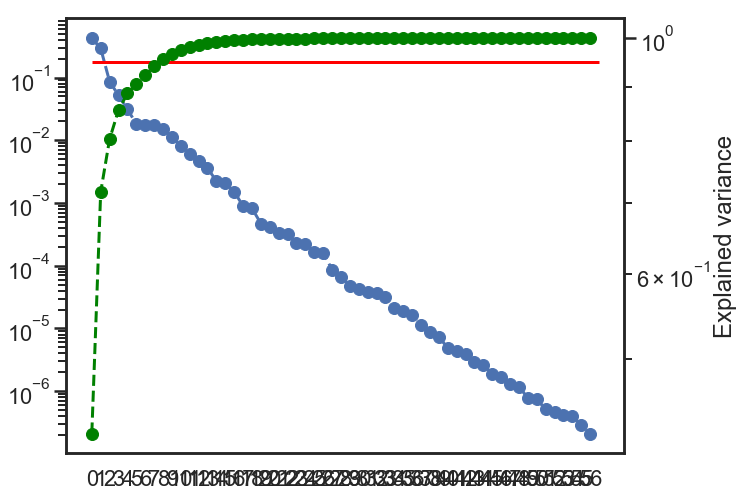

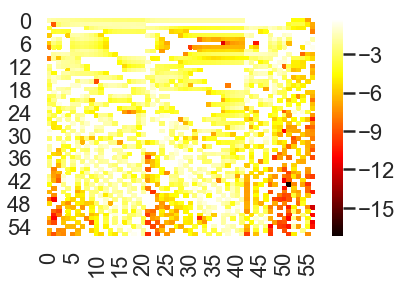

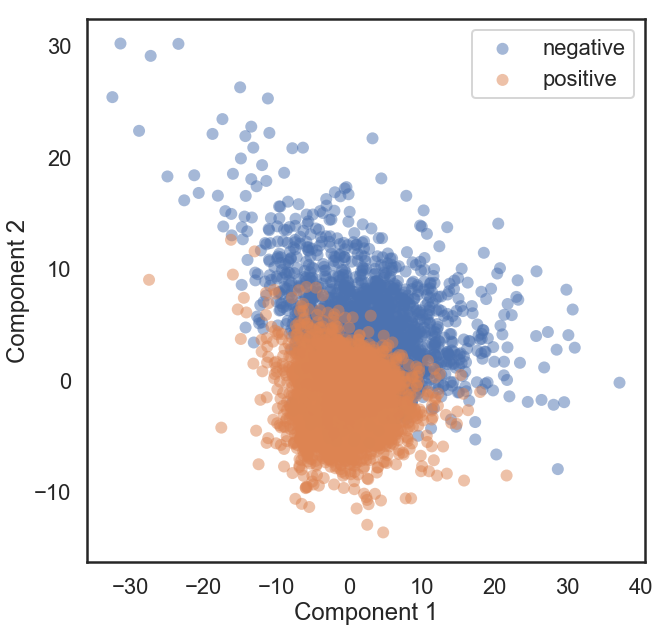

In [47]:
%%skip $skip_feature_analysis
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

pca_trafo = PCA().fit(X_scaled);
pca_values = pca_trafo.transform(X_scaled)
#from adjustText import adjust_text
targets = np.array(y).flatten()

fig, ax1 = plt.subplots(figsize=(10, 8))
plt.semilogy(pca_trafo.explained_variance_ratio_, '--o');
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.semilogy(pca_trafo.explained_variance_ratio_.cumsum(), '--o', color='green');
plt.xlabel("Principal Component")
plt.ylabel("Explained variance")
plt.xticks(np.arange(0, len(pca_trafo.explained_variance_ratio_)))
plt.hlines(0.95, 0, len(pca_trafo.explained_variance_ratio_.cumsum()), colors='red', linestyles='solid', label='95% variance covered')

fig = plt.figure()
sns.heatmap(np.log(pca_trafo.inverse_transform(np.eye(X_scaled.shape[1]))), cmap="hot", cbar=True)

necessary_components = pca_trafo.explained_variance_ratio_.cumsum()[pca_trafo.explained_variance_ratio_.cumsum()<0.95]
print("95% variance covered with the {} first components. Values={}". format(len(necessary_components), necessary_components))

plt.figure(figsize=(10,10))
#plt.scatter(pca_values[:,0], pca_values[:,1], c=targets, edgecolor='none', label=class_labels.values(), alpha=0.5)
for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(pca_values[idx, 0], pca_values[idx, 1], label=class_labels[t], edgecolor='none', alpha=0.5)  

plt.legend(labels=class_labels.values(), bbox_to_anchor=(1, 1));
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## Feature Selection

In [48]:
#Select a random subset to visualize
import random

#Reduce the training set with the number of samples randomly chosen
X_train_index_subset = sup.get_data_subset_index(1000, X_scaled)

relevantFeatureList = []
selected_feature_list = pd.DataFrame()

Cutting the data to  1000
Created a training subset


### Lasso Feature Selection

Best alpha using built-in LassoCV: 0.005261
Best score using built-in LassoCV: 0.552582
Lasso picked 6 variables and eliminated the other 51 variables
['MA250Norm', 'MA225Norm', 'MA5Norm', 'MA10Norm', 'MA20Norm', 'RSI25']


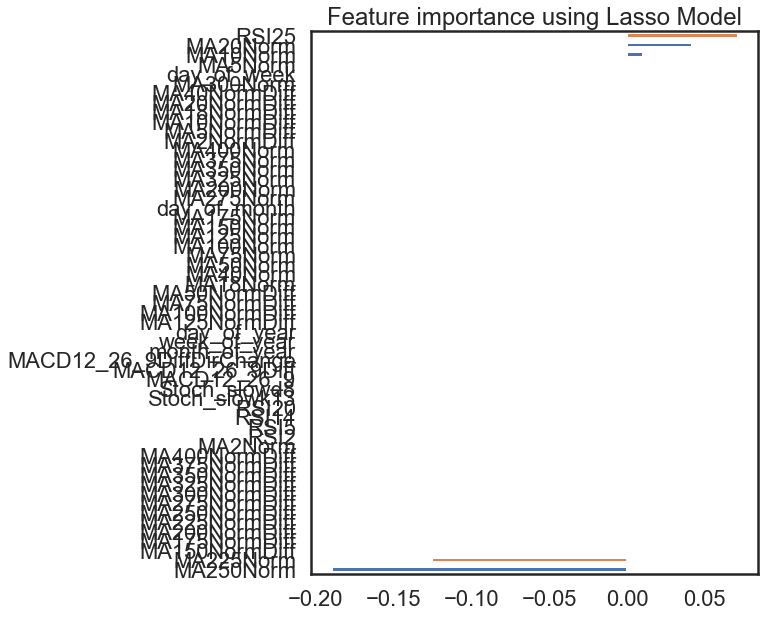

In [49]:
%%skip $skip_feature_selection
#%matplotlib inline
from sklearn.linear_model import LassoCV

def execute_lasso_feature_selection(X_scaled, y):
    reg = LassoCV(cv=10, max_iter = 100000)
    reg.fit(X_scaled, y)
    coef = pd.Series(reg.coef_, index = X_scaled.columns)
    print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
    print("Best score using built-in LassoCV: %f" %reg.score(X_scaled,y))
    print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    imp_coef = coef.sort_values()
    coefList = list(imp_coef[imp_coef!=0].index)
    print(coefList)

    #plt.figure()
    m.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Lasso Model")
    plt.show()
    
    return coefList
    
#if do_feature_analysis==True:
coefList = execute_lasso_feature_selection(X_scaled, y)
selected_feature_list = selected_feature_list.append(pd.Series(name='Lasso', data=coefList))
relevantFeatureList.extend(coefList)

### Tree based feature selection

[0.002 0.004 0.005 0.006 0.006 0.009 0.012 0.026 0.036 0.036 0.045 0.046
 0.093 0.073 0.069 0.076 0.047 0.052 0.057 0.067 0.051 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.003 0.003 0.002 0.003 0.003 0.002 0.003
 0.002 0.002 0.002 0.002 0.002 0.002 0.004 0.008 0.013 0.019 0.013 0.008
 0.01  0.009 0.005 0.003 0.011 0.013 0.012 0.004 0.002]
Tree search picked 21 variables and eliminated the other 36 variables
['month_of_year', 'day_of_year', 'MA50Norm', 'RSI14', 'week_of_year', 'RSI25', 'RSI20', 'MA75Norm', 'MA125Norm', 'MA100Norm', 'MA150Norm', 'MA175Norm', 'MA300Norm', 'MA400Norm', 'MA325Norm', 'MA350Norm', 'MA375Norm', 'MA250Norm', 'MA225Norm', 'MA275Norm', 'MA200Norm']


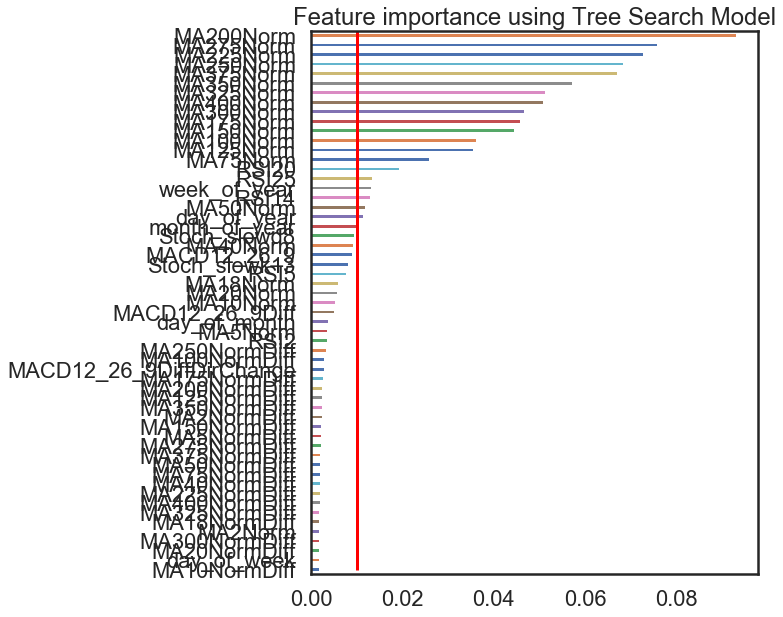

In [50]:
%%skip $skip_feature_selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

def execute_treebased_feature_selection(X_scaled, y):
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X_scaled, y)
    print(clf.feature_importances_) 
    model = SelectFromModel(clf, prefit=True)
    X_new = model.transform(X_scaled)
    X_new.shape

    threshold = 0.010
    tree_coef = pd.Series(clf.feature_importances_, index = X_scaled.columns)

    print("Tree search picked " + str(sum(tree_coef >= threshold)) + " variables and eliminated the other " +  str(sum(tree_coef < threshold)) + " variables")
    imp_treecoef = tree_coef.sort_values()
    treecoefList = list(imp_treecoef[imp_treecoef>threshold].index)
    print(treecoefList)

    plt.figure()
    m.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_treecoef.plot(kind = "barh")
    plt.title("Feature importance using Tree Search Model")
    plt.vlines(threshold, 0, len(X_scaled.columns), color='red')
    plt.show()
    
    return treecoefList

#if do_feature_analysis==True:
treecoefList = execute_treebased_feature_selection(X_scaled, y)
selected_feature_list = selected_feature_list.append(pd.Series(name='Tree', data=treecoefList))
relevantFeatureList.extend(treecoefList)

### Backward Elimination

In [51]:
%%skip $skip_feature_selection
#Backward Elimination - Wrapper method
import statsmodels.api as sm

def execute_backwardelimination_feature_selection(X_scaled, y):
    cols = list(X_scaled.columns)
    pmax = 1
    while (len(cols)>0):
        p= []
        X_1 = X_scaled[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y,X_1).fit()
        p = pd.Series(model.pvalues.values[1:],index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = cols

    print(selected_features_BE)
    print("\nNumber of features={}. Original number of features={}\n".format(len(selected_features_BE), len(X_scaled.columns)))
    [print("column {} removed".format(x)) for x in X_scaled.columns if x not in selected_features_BE]
    print("Finished")
    
    return selected_features_BE

#if do_feature_analysis==True:
selected_features_BE = execute_backwardelimination_feature_selection(X_scaled, y)
relevantFeatureList.extend(selected_features_BE)
selected_feature_list = selected_feature_list.append(pd.Series(name='Backward_Elimination', data=selected_features_BE))

['MA20Norm', 'MA75Norm', 'MA100Norm', 'MA125Norm', 'MA150Norm', 'MA200Norm', 'MA225Norm', 'MA250Norm', 'MA375Norm', 'MA75NormDiff', 'MA125NormDiff', 'MA175NormDiff', 'MA225NormDiff', 'MA325NormDiff', 'MA350NormDiff', 'MA375NormDiff', 'MA400NormDiff', 'RSI5', 'RSI14', 'RSI20', 'RSI25', 'month_of_year', 'day_of_year', 'day_of_month']

Number of features=24. Original number of features=57

column MA2Norm removed
column MA5Norm removed
column MA10Norm removed
column MA18Norm removed
column MA40Norm removed
column MA50Norm removed
column MA175Norm removed
column MA275Norm removed
column MA300Norm removed
column MA325Norm removed
column MA350Norm removed
column MA400Norm removed
column MA2NormDiff removed
column MA5NormDiff removed
column MA10NormDiff removed
column MA18NormDiff removed
column MA20NormDiff removed
column MA40NormDiff removed
column MA50NormDiff removed
column MA100NormDiff removed
column MA150NormDiff removed
column MA200NormDiff removed
column MA250NormDiff removed
column M

### Recursive Elimination with Logistic Regression

In [52]:
%%skip $skip_feature_selection
#Recursive Elimination - Wrapper method, Feature ranking with recursive feature elimination
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFE

def execute_recursive_elimination_feature_selection(X_scaled, y):
    model = LogisticRegressionCV(solver='liblinear', cv=3)
    print("Start Recursive Elimination. Fit model with {} examples.".format(X_scaled.shape[0]))
    #Initializing RFE model, 3 features selected
    rfe = RFE(model, 1) #It has to be one to get a unique index
    #Transforming data using RFE
    X_rfe = rfe.fit_transform(X_scaled,y)
    #Fitting the data to model
    model.fit(X_rfe,y)

    print("Best accuracy score using built-in Logistic Regression: ", model.score(X_rfe, y))
    print("Ranking")
    rfe_coef = pd.Series(X_scaled.columns, index = rfe.ranking_-1).sort_index()
    print(rfe_coef)
    print("Select columns")

    
    print(X_scaled.columns[rfe.support_].values)
    
    return X_scaled.columns[rfe.support_].values, rfe_coef

#if do_feature_analysis==True:
relevant_features, rfe_coef = execute_recursive_elimination_feature_selection(X_scaled.iloc[X_train_index_subset], y[X_train_index_subset])
relevantFeatureList.extend(relevant_features)

step_size = np.round(len(X_scaled.columns)/4,0).astype("int")
for i in range(step_size, len(X_scaled.columns), step_size):
    selected_feature_list = selected_feature_list.append(pd.Series(name='RecursiveTop' + str(i), data=rfe_coef.loc[0:i-1]))
    print('Created RecursiveTop{}'.format(str(i)))

Start Recursive Elimination. Fit model with 1000 examples.
Best accuracy score using built-in Logistic Regression:  0.692
Ranking
0                MA375NormDiff
1                MA250NormDiff
2                    MA275Norm
3                    MA375Norm
4                MA350NormDiff
5                MA225NormDiff
6                 week_of_year
7                  day_of_year
8                    MA325Norm
9                    MA150Norm
10                    MA75Norm
11                   MA125Norm
12                    MA50Norm
13                   MA250Norm
14                     MA2Norm
15                   MA225Norm
16               MA300NormDiff
17               MA100NormDiff
18               MA325NormDiff
19                   MA400Norm
20                       RSI14
21                       RSI25
22                    MA10Norm
23               month_of_year
24                        RSI2
25               MA125NormDiff
26                MA75NormDiff
27                Stoch_slowd8
28

In [53]:
#rfe_coef.loc[0:10].values

### Weighted values

In [54]:
#Weights
values, counts = np.unique(relevantFeatureList, return_counts=True)
s = pd.Series(index=values, data=counts).sort_values(ascending=False)
print(s)

MA250Norm        3
MA225Norm        3
RSI25            3
MA75Norm         2
month_of_year    2
MA20Norm         2
MA375Norm        2
MA375NormDiff    2
MA200Norm        2
MA100Norm        2
RSI14            2
RSI20            2
MA125Norm        2
day_of_year      2
MA150Norm        2
MA275Norm        1
MA175Norm        1
MA175NormDiff    1
MA125NormDiff    1
MA10Norm         1
MA225NormDiff    1
week_of_year     1
MA300Norm        1
MA325Norm        1
MA325NormDiff    1
MA350NormDiff    1
MA400Norm        1
MA400NormDiff    1
MA50Norm         1
MA5Norm          1
MA75NormDiff     1
RSI5             1
day_of_month     1
MA350Norm        1
dtype: int64


### Add Manually Selected Subset

In [55]:
#print subset
newval = [x for x, c in zip(values, counts) if c>1]
subsetColumns = newval#X.columns[rfe.support_].values #list(values)
display(subsetColumns)
selected_feature_list = selected_feature_list.append(pd.Series(name='Manual', data=subsetColumns))

['MA100Norm',
 'MA125Norm',
 'MA150Norm',
 'MA200Norm',
 'MA20Norm',
 'MA225Norm',
 'MA250Norm',
 'MA375Norm',
 'MA375NormDiff',
 'MA75Norm',
 'RSI14',
 'RSI20',
 'RSI25',
 'day_of_year',
 'month_of_year']

### Add all columns

In [56]:
selected_feature_list = selected_feature_list.append(pd.Series(name='All', data=X_scaled.columns))

In [57]:
#subsetColumns = X.columns[rfe.support_].values
#X_subset = X_raw[subsetColumns]
#display(X_subset.head(5))
selected_feature_list.transpose()

Lasso           Tree Backward_Elimination RecursiveTop14  \
0   MA250Norm  month_of_year             MA20Norm  MA375NormDiff   
1   MA225Norm    day_of_year             MA75Norm  MA250NormDiff   
2     MA5Norm       MA50Norm            MA100Norm      MA275Norm   
3    MA10Norm          RSI14            MA125Norm      MA375Norm   
4    MA20Norm   week_of_year            MA150Norm  MA350NormDiff   
5       RSI25          RSI25            MA200Norm  MA225NormDiff   
6         NaN          RSI20            MA225Norm   week_of_year   
7         NaN       MA75Norm            MA250Norm    day_of_year   
8         NaN      MA125Norm            MA375Norm      MA325Norm   
9         NaN      MA100Norm         MA75NormDiff      MA150Norm   
10        NaN      MA150Norm        MA125NormDiff       MA75Norm   
11        NaN      MA175Norm        MA175NormDiff      MA125Norm   
12        NaN      MA300Norm        MA225NormDiff       MA50Norm   
13        NaN      MA400Norm        MA325NormDiff      MA250Norm   
14        NaN      MA325Norm        MA350NormDiff            NaN   
15        NaN      MA350Norm        MA375NormDiff            NaN   
16        NaN      MA375Norm        MA400NormDiff            NaN   
17        NaN      MA250Norm                 RSI5            NaN   
18        NaN      MA225Norm                RSI14            NaN   
19        NaN      MA275Norm                RSI20            NaN   
20        NaN      MA200Norm                RSI25            NaN   
21        NaN            NaN        month_of_year            NaN   
22        NaN            NaN          day_of_year            NaN   
23        NaN            NaN         day_of_month            NaN   
24        NaN            NaN                  NaN            NaN   
25        NaN            NaN                  NaN            NaN   
26        NaN            NaN                  NaN            NaN   
27        NaN            NaN                  NaN            NaN   
28        NaN            NaN                  NaN            NaN   
29        NaN            NaN                  NaN            NaN   
30        NaN            NaN                  NaN            NaN   
31        NaN            NaN                  NaN            NaN   
32        NaN            NaN                  NaN            NaN   
33        NaN            NaN                  NaN            NaN   
34        NaN            NaN                  NaN            NaN   
35        NaN            NaN                  NaN            NaN   
36        NaN            NaN                  NaN            NaN   
37        NaN            NaN                  NaN            NaN   
38        NaN            NaN                  NaN            NaN   
39        NaN            NaN                  NaN            NaN   
40        NaN            NaN                  NaN            NaN   
41        NaN            NaN                  NaN            NaN   
42        NaN            NaN                  NaN            NaN   
43        NaN            NaN                  NaN            NaN   
44        NaN            NaN                  NaN            NaN   
45        NaN            NaN                  NaN            NaN   
46        NaN            NaN                  NaN            NaN   
47        NaN            NaN                  NaN            NaN   
48        NaN            NaN                  NaN            NaN   
49        NaN            NaN                  NaN            NaN   
50        NaN            NaN                  NaN            NaN   
51        NaN            NaN                  NaN            NaN   
52        NaN            NaN                  NaN            NaN   
53        NaN            NaN                  NaN            NaN   
54        NaN            NaN                  NaN            NaN   
55        NaN            NaN                  NaN            NaN   
56        NaN            NaN                  NaN            NaN   

   RecursiveTop28 RecursiveTop42            RecursiveTop56     

## Save Subset

In [58]:
import csv

#Save features to a csv file
print("Original features shape={}, features shape {}".format(df.shape, X_raw.shape))
X_raw.to_csv(X_filename, sep=';', index=True)
#np.savetxt(filenameprefix + "_X.csv", X, delimiter=";", fmt='%s')
print("Saved features to " + X_filename)

#Save y to a csv file
print("y shape {}".format(y.shape))
y_raw.to_csv(y_filename, sep=';', index=True, header=True)
print("Saved features to " + y_filename)

#Save y labels to a csv file as a dict
#print("Class labels length {}".format(len(y_labels)))
#with open(ylabel_filename, 'w') as f:
#    for key in y_labels.keys():
#        f.write("%s;%s\n"%(key,y_labels[key]))
#print("Saved class names and id to " + ylabel_filename)

#Save x subset column names to a csv file as a list
selected_feature_list.transpose().to_csv(X_filename_selected_feature_column, sep=';', index=False, header=True)
#print("Selected columns length {}".format(len(subsetColumns)))
#with open(X_filename_selected_feature_column, 'w') as f:
#    for item in subsetColumns:
#        f.write("%s\n"%(item))
print("Saved selected feature columns to " + X_filename_selected_feature_column)

print("=== Data for {} prepared to be trained ===". format(filenameprefix))

Original features shape=(7687, 58), features shape (7687, 57)
Saved features to 02_Training_Data/omxs30_LongTrend_X.csv
y shape (7687,)
Saved features to 02_Training_Data/omxs30_LongTrend_y.csv
Saved selected feature columns to 02_Training_Data/omxs30_LongTrend_X_selected_feature_columns.csv
=== Data for omxs30_LongTrend prepared to be trained ===


## Debug and Experiment

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 20, 30, 40, 50, 64],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')

from tqdm import tqdm
import time
%matplotlib inline

pbar = tqdm(total=100)
for i in range(10):
    time.sleep(0.1)
    pbar.update(10)
pbar.close()

from statsmodels import robust

a = np.matrix( [
    [ 80, 76, 77, 78, 79, 81, 76, 77, 79, 84, 75, 79, 76, 78 ],
    [ 66, 69, 76, 72, 79, 77, 74, 77, 71, 79, 74, 66, 67, 73 ]
    ], dtype=float )
robust.mad(a, axis=1)

from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_timegraph['Close'])
plt.show()